In [ ]:
import sys
import logging
import numpy as np
from joblib import hash, dump
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
import deer.controllers as bc
from deer.environments.Catcher import MyEnv as Env

from deer.policies import EpsilonGreedyPolicy

In [ ]:
class Defaults:
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 2000
    epochs = 50
    steps_per_test = 500
    period_btw_summary_perfs = 1
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    update_rule = 'rmsprop'
    learning_rate = 0.0005
    learning_rate_decay = 0.9
    discount = 0.9
    discount_inc = 1
    discount_max = 0.99
    rms_decay = 0.9
    rms_epsilon = 0.0001
    momentum = 0
    clip_norm = 1.0
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 10000
    update_frequency = 1
    replay_memory_size = 1000000
    batch_size = 32
    freeze_interval = 1000
    deterministic = False

HIGHER_DIM_OBS = True
HIGH_INT_DIM = False

In [ ]:
parameters = Defaults()
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

In [ ]:
# --- Instantiate environment ---
env = catcher_env(rng, higher_dim_obs=HIGHER_DIM_OBS, reverse=False)

# --- Instantiate learning algorithm ---
learning_algo = CRAR(
    env,
    parameters.rms_decay,
    parameters.rms_epsilon,
    parameters.momentum,
    parameters.clip_norm,
    parameters.freeze_interval,
    parameters.batch_size,
    parameters.update_rule,
    rng,
    double_Q=True,
    high_int_dim=HIGH_INT_DIM,
    internal_dim=3)

test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)

# --- Instantiate agent ---
agent = NeuralAgent(
    env,
    learning_algo,
    parameters.replay_memory_size,
    max(env.inputDimensions()[i][0] for i in range(len(env.inputDimensions()))),
    parameters.batch_size,
    rng,
    test_policy=test_policy)

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# As for the discount factor and the learning rate, one can update periodically the parameter of the epsilon-greedy
# policy implemented by the agent. This controllers has a bit more capabilities, as it allows one to choose more
# precisely when to update epsilon: after every X action, episode or epoch. This parameter can also be reset every
# episode or epoch (or never, hence the resetEvery='none').
agent.attach(bc.EpsilonController(
    initial_e=parameters.epsilon_start, 
    e_decays=parameters.epsilon_decay, 
    e_min=parameters.epsilon_min,
    evaluate_on='action',
    periodicity=1,
    reset_every='none'))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=catcher_env.VALIDATION_MODE,
    testID=None,
    unique_fname=f"{fname}"))

# Every epoch end, one has the possibility to modify the learning rate using a LearningRateController. Here we 
# wish to update the learning rate after every training epoch (periodicity=1), according to the parameters given.
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# Same for the discount factor.
agent.attach(bc.DiscountFactorController(
    initial_discount_factor=parameters.discount, 
    discount_factor_growth=parameters.discount_inc, 
    discount_factor_max=parameters.discount_max,
    periodicity=1))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch ("one of two epochs", hence the periodicity=2). We do not want 
# these validation epoch to interfere with the training of the agent, which is well established by the 
# TrainerController, EpsilonController and alike. Therefore, we will disable these controllers for the whole 
# duration of the validation epochs interleaved this way, using the controllersToDisable argument of the 
# InterleavedTestEpochController. For each validation epoch, we want also to display the sum of all rewards 
# obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env every 
# [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=catcher_env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1))

In [6]:
# --- Run the experiment ---
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
agent.run(parameters.epochs, parameters.steps_per_epoch)

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2070,  0.0249, -0.2277], device='cuda:0') tensor([-0.0761,  0.4696, -0.0573], device='cuda:0') tensor([-0.2061,  0.0247, -0.2287], device='cuda:0')
R[0]
tensor([0.1810], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.00018334352256488273
Episode average V value: 0
Average (on the epoch) training loss: 0.04661249943881236
Episode average V value: 0
Average (on the epoch) training loss: 0.061794693946379854
Episode average V value: 0
Average (on the epoch) training loss: 0.0709240395091261
Episode average V value: 0
Average (on the epoch) training loss: 0.07522782950977878
Episode average V value: 0
Average (on the epoch) training loss: 0.08166642835731353
Episode average V value: 0
Average (on the epoch) training loss: 0.08633279713936029
Episode average V value: 0
Average (on the epoch) training loss: 0.0880764

Average (on the epoch) training loss: 0.09770314454311729
Episode average V value: 0
Average (on the epoch) training loss: 0.09756330583252709
Episode average V value: 0
Average (on the epoch) training loss: 0.09713613181424932
Episode average V value: 0
Average (on the epoch) training loss: 0.09686407556044645
Episode average V value: 0
Average (on the epoch) training loss: 0.09658352961962892
Episode average V value: 0
Average (on the epoch) training loss: 0.09612682332054924
Episode average V value: 0
Average (on the epoch) training loss: 0.09568489081626134
Episode average V value: 0
Average (on the epoch) training loss: 0.0955170477927053
Episode average V value: 0
Average (on the epoch) training loss: 0.09537791331024836
Episode average V value: 0
Average (on the epoch) training loss: 0.095497638684743
Episode average V value: 0
Average (on the epoch) training loss: 0.09530870066018937
Episode average V value: 0
Average (on the epoch) training loss: 0.09504387653124023
Episode av

Average (on the epoch) training loss: 0.0789817424119519
Episode average V value: 0
Average (on the epoch) training loss: 0.07883258895653279
Episode average V value: 0
Average (on the epoch) training loss: 0.07867400546291459
Episode average V value: 0
Average (on the epoch) training loss: 0.07839266677873022
Episode average V value: 0
Average (on the epoch) training loss: 0.07819991123519147
Episode average V value: 0
Average (on the epoch) training loss: 0.07792777760086825
Episode average V value: 0
Average (on the epoch) training loss: 0.07774606324355726
Episode average V value: 0
Average (on the epoch) training loss: 0.07753883060499576
Episode average V value: 0
Average (on the epoch) training loss: 0.077305851789932
Episode average V value: 0
Average (on the epoch) training loss: 0.07717396148855271
Episode average V value: 0
Average (on the epoch) training loss: 0.0770724955228181
Episode average V value: 0
Average (on the epoch) training loss: 0.07695230511035976
Episode ave

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/share/ctn/users/cf2794/Code/deer/deer/learning_algos/CRAR_torch.py:390: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  state = torch.as_tensor(state, device=self.device).float()


Testing score per episode (id: 0) is 0.3392857142857143 (average over 56 episode(s))
== Mean score per episode is 0.33928510841944926 over 56 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.015860880648717286 0.057782385820522905 0.023236250063870104 0.05070142632909119 0.06642225942015648 0.0005712060183286667 0.044059299996122715
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1625, -1.0060,  0.6988], device='cuda:0') tensor([ 0.6134, -0.9160,  0.6410], device='cuda:0') tensor([ 0.5711, -0.9310,  0.6296], device='cuda:0')
R[0]
tensor([-0.0834], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.062452656113439135
Episode average V value: 0
Average (on the epoch) training loss: 0.0501529433661037
Episode average V value: 0
Average (on the epoch) training loss: 0.04387112525809142
Episode average V value: 0
Average (on the epoch) training loss: 0.04633630914354904
Episode average V value: 0

Average (on the epoch) training loss: 0.044428816183633514
Episode average V value: 0
Average (on the epoch) training loss: 0.044451612592662476
Episode average V value: 0
Average (on the epoch) training loss: 0.044556406216111545
Episode average V value: 0
Average (on the epoch) training loss: 0.04456707553785217
Episode average V value: 0
Average (on the epoch) training loss: 0.04459822053145641
Episode average V value: 0
Average (on the epoch) training loss: 0.044406653563856535
Episode average V value: 0
Average (on the epoch) training loss: 0.04466606135894027
Episode average V value: 0
Average (on the epoch) training loss: 0.04453599185389639
Episode average V value: 0
Average (on the epoch) training loss: 0.04448190105707136
Episode average V value: 0
Average (on the epoch) training loss: 0.04455476747583913
Episode average V value: 0
Average (on the epoch) training loss: 0.04452765589355176
Episode average V value: 0
Average (on the epoch) training loss: 0.04464312270063528
Epi

Average (on the epoch) training loss: 0.04186623006250349
Episode average V value: 0
Average (on the epoch) training loss: 0.04194024700336501
Episode average V value: 0
Average (on the epoch) training loss: 0.041880755634899285
Episode average V value: 0
Average (on the epoch) training loss: 0.042049894220261674
Episode average V value: 0
Average (on the epoch) training loss: 0.04196725867388443
Episode average V value: 0
Average (on the epoch) training loss: 0.04197310457259115
Episode average V value: 0
Average (on the epoch) training loss: 0.041872002241334916
Episode average V value: 0
Average (on the epoch) training loss: 0.04187676792092148
Episode average V value: 0
Average (on the epoch) training loss: 0.04184419289437085
Episode average V value: 0
Average (on the epoch) training loss: 0.04189520452156364
Episode average V value: 0
Average (on the epoch) training loss: 0.04190058306210701
Episode average V value: 0
Average (on the epoch) training loss: 0.04197097254378234
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.012100292985327542 0.031683799042832105 0.024619219380430876 0.038543680463917554 0.0356292384415865 0.00038590507209301 0.03762214131141081
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1988, -0.7786,  0.9842], device='cuda:0') tensor([ 0.7462, -0.3386,  0.9172], device='cuda:0') tensor([ 0.7748, -0.3497,  0.9377], device='cuda:0')
R[0]
tensor([0.0223], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.03945576513393058
Episode average V value: 0
Average (on the epoch) training loss: 0.0388002286458181
Episode average V value: 0
Average (on the epoch) training loss: 0.04697359394696024
Episode average V value: 0
Average (on the epoch) training loss: 0.04903249809932378
Episode average V value: 0
Aver

Average (on the epoch) training loss: 0.03883426258286868
Episode average V value: 0
Average (on the epoch) training loss: 0.03875448690110167
Episode average V value: 0
Average (on the epoch) training loss: 0.038827911518161104
Episode average V value: 0
Average (on the epoch) training loss: 0.038844764500661474
Episode average V value: 0
Average (on the epoch) training loss: 0.03876596748190165
Episode average V value: 0
Average (on the epoch) training loss: 0.038541031982267576
Episode average V value: 0
Average (on the epoch) training loss: 0.038536504813564125
Episode average V value: 0
Average (on the epoch) training loss: 0.038514815092972124
Episode average V value: 0
Average (on the epoch) training loss: 0.03831805655663385
Episode average V value: 0
Average (on the epoch) training loss: 0.038416879021299435
Episode average V value: 0
Average (on the epoch) training loss: 0.03856332095149624
Episode average V value: 0
Average (on the epoch) training loss: 0.03835530098539779
E

Average (on the epoch) training loss: 0.040641496762945616
Episode average V value: 0
Average (on the epoch) training loss: 0.040605209116244725
Episode average V value: 0
Average (on the epoch) training loss: 0.040597536291826664
Episode average V value: 0
Average (on the epoch) training loss: 0.0404979442209193
Episode average V value: 0
Average (on the epoch) training loss: 0.04041714336774529
Episode average V value: 0
Average (on the epoch) training loss: 0.04037592969450492
Episode average V value: 0
Average (on the epoch) training loss: 0.04033568708663497
Episode average V value: 0
Average (on the epoch) training loss: 0.04049682168785246
Episode average V value: 0
Average (on the epoch) training loss: 0.04063433194890174
Episode average V value: 0
Average (on the epoch) training loss: 0.040672393395782935
Episode average V value: 0
Average (on the epoch) training loss: 0.04076997258375747
Episode average V value: 0
Average (on the epoch) training loss: 0.04067058818353239
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.010463572794571519 0.028385277815628798 0.016187154627637937 0.03993015939835459 0.028718786112964155 0.0003630547374486923 0.03568429351435043
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0400, -0.5882,  0.6967], device='cuda:0') tensor([ 0.4642, -0.2587,  0.7580], device='cuda:0') tensor([ 0.3761, -0.3537,  0.6904], device='cuda:0')
R[0]
tensor([-0.0063], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.03398380366464456
Episode average V value: 0
Average (on the epoch) training loss: 0.04510932746860716
Episode average V value: 0
Average (on the epoch) training loss: 0.04576039828222107
Episode average V value: 0
Average (on the epoch) training loss: 0.04874141258187592
Episode average V value: 0

Average (on the epoch) training loss: 0.04284773909311038
Episode average V value: 0
Average (on the epoch) training loss: 0.04290250205513701
Episode average V value: 0
Average (on the epoch) training loss: 0.04267391781474835
Episode average V value: 0
Average (on the epoch) training loss: 0.04254292670122374
Episode average V value: 0
Average (on the epoch) training loss: 0.04254720462985708
Episode average V value: 0
Average (on the epoch) training loss: 0.04245229210584622
Episode average V value: 0
Average (on the epoch) training loss: 0.04235851922515459
Episode average V value: 0
Average (on the epoch) training loss: 0.04234434005022509
Episode average V value: 0
Average (on the epoch) training loss: 0.042339301634561705
Episode average V value: 0
Average (on the epoch) training loss: 0.04238897054242465
Episode average V value: 0
Average (on the epoch) training loss: 0.04259082447045361
Episode average V value: 0
Average (on the epoch) training loss: 0.04228121049957566
Episod

Average (on the epoch) training loss: 0.04307028275659485
Episode average V value: 0
Average (on the epoch) training loss: 0.04306352640459905
Episode average V value: 0
Average (on the epoch) training loss: 0.042982227423264845
Episode average V value: 0
Average (on the epoch) training loss: 0.043013084425528605
Episode average V value: 0
Average (on the epoch) training loss: 0.04295428380209505
Episode average V value: 0
Average (on the epoch) training loss: 0.0429360890273823
Episode average V value: 0
Average (on the epoch) training loss: 0.04303068633677169
Episode average V value: 0
Average (on the epoch) training loss: 0.04300956178855683
Episode average V value: 0
Average (on the epoch) training loss: 0.04296162202904316
Episode average V value: 0
Average (on the epoch) training loss: 0.04292483495478796
Episode average V value: 0
Average (on the epoch) training loss: 0.04287692061965511
Episode average V value: 0
Average (on the epoch) training loss: 0.042727303870853606
Episo

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.010603470149915665 0.023767790428129956 0.0050875501825939865 0.03885830559534952 0.028276318125426768 0.0002734684944152832 0.03618639567075297
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.8261, -0.1920, -0.8684], device='cuda:0') tensor([-0.7993, -0.5134, -0.0555], device='cuda:0') tensor([-0.6966, -0.5502, -0.1961], device='cuda:0')
R[0]
tensor([0.1235], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.04828129905379481
Episode average V value: 0
Average (on the epoch) training loss: 0.04228535387665033
Episode average V value: 0
Average (on the epoch) training loss: 0.04222291449291839
Episode average V value: 0
Average (on the epoch) training loss: 0.044656739466720156
Episode average V value: 

Average (on the epoch) training loss: 0.03950946583472432
Episode average V value: 0
Average (on the epoch) training loss: 0.03942098720374926
Episode average V value: 0
Average (on the epoch) training loss: 0.03929416675613645
Episode average V value: 0
Average (on the epoch) training loss: 0.039158083721983324
Episode average V value: 0
Average (on the epoch) training loss: 0.03943875322289679
Episode average V value: 0
Average (on the epoch) training loss: 0.03922977694075065
Episode average V value: 0
Average (on the epoch) training loss: 0.039273041106304724
Episode average V value: 0
Average (on the epoch) training loss: 0.039505177745480596
Episode average V value: 0
Average (on the epoch) training loss: 0.03928233446241772
Episode average V value: 0
Average (on the epoch) training loss: 0.03932858097528958
Episode average V value: 0
Average (on the epoch) training loss: 0.039319322014443374
Episode average V value: 0
Average (on the epoch) training loss: 0.03942417890195631
Epi

Average (on the epoch) training loss: 0.039831487924660056
Episode average V value: 0
Average (on the epoch) training loss: 0.03996144746550231
Episode average V value: 0
Average (on the epoch) training loss: 0.040027277198547095
Episode average V value: 0
Average (on the epoch) training loss: 0.04004916857248456
Episode average V value: 0
Average (on the epoch) training loss: 0.04003094697809713
Episode average V value: 0
Average (on the epoch) training loss: 0.04003350931942324
Episode average V value: 0
Average (on the epoch) training loss: 0.039966421796985466
Episode average V value: 0
Average (on the epoch) training loss: 0.04001297508721195
Episode average V value: 0
Average (on the epoch) training loss: 0.0400004425717252
Episode average V value: 0
Average (on the epoch) training loss: 0.040059470023628974
Episode average V value: 0
Average (on the epoch) training loss: 0.04005811226943138
Episode average V value: 0
Average (on the epoch) training loss: 0.03997275520802298
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.009348036866169423 0.025171366152819247 0.0036102069864282385 0.040066558383405206 0.028411861572414637 0.0003008919656276703 0.034876529372297224
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4944,  0.5261, -0.7677], device='cuda:0') tensor([-0.8779,  0.1891,  0.2394], device='cuda:0') tensor([-0.9086,  0.2213,  0.3392], device='cuda:0')
R[0]
tensor([-0.0493], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.034582520110739604
Episode average V value: 0
Average (on the epoch) training loss: 0.027318569572849408
Episode average V value: 0
Average (on the epoch) training loss: 0.03130214119812957
Episode average V value: 0
Average (on the epoch) training loss: 0.029989323837475643
Episode average V va

Average (on the epoch) training loss: 0.04099370881203198
Episode average V value: 0
Average (on the epoch) training loss: 0.040917555874560974
Episode average V value: 0
Average (on the epoch) training loss: 0.04090203577865621
Episode average V value: 0
Average (on the epoch) training loss: 0.04079375738574033
Episode average V value: 0
Average (on the epoch) training loss: 0.04068399983782935
Episode average V value: 0
Average (on the epoch) training loss: 0.04059855524401152
Episode average V value: 0
Average (on the epoch) training loss: 0.040823912531132815
Episode average V value: 0
Average (on the epoch) training loss: 0.040659046627834074
Episode average V value: 0
Average (on the epoch) training loss: 0.04070537770849281
Episode average V value: 0
Average (on the epoch) training loss: 0.04074255362600718
Episode average V value: 0
Average (on the epoch) training loss: 0.040723470686695656
Episode average V value: 0
Average (on the epoch) training loss: 0.04049551308465501
Epi

Average (on the epoch) training loss: 0.04185829556143039
Episode average V value: 0
Average (on the epoch) training loss: 0.04183853448801512
Episode average V value: 0
Average (on the epoch) training loss: 0.041872096686849214
Episode average V value: 0
Average (on the epoch) training loss: 0.04176118866497526
Episode average V value: 0
Average (on the epoch) training loss: 0.04177979274065708
Episode average V value: 0
Average (on the epoch) training loss: 0.041733204661680096
Episode average V value: 0
Average (on the epoch) training loss: 0.04191227327071197
Episode average V value: 0
Average (on the epoch) training loss: 0.041960694199753186
Episode average V value: 0
Average (on the epoch) training loss: 0.0419598557866376
Episode average V value: 0
Average (on the epoch) training loss: 0.04191227484440661
Episode average V value: 0
Average (on the epoch) training loss: 0.04182787012563467
Episode average V value: 0
Average (on the epoch) training loss: 0.04183664247925462
Episo

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008941926483530552 0.023124025281053038 0.003919918485800735 0.04105226310575381 0.02879995656386018 0.0002771766260266304 0.03657334454613738
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2995, -0.7773,  0.5561], device='cuda:0') tensor([ 0.3553, -0.5304,  0.7461], device='cuda:0') tensor([ 0.3738, -0.4456,  0.6988], device='cuda:0')
R[0]
tensor([-0.0092], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.04617918313791355
Episode average V value: 0
Average (on the epoch) training loss: 0.04235703099725975
Episode average V value: 0
Average (on the epoch) training loss: 0.03961345637907033
Episode average V value: 0
Average (on the epoch) training loss: 0.04344882920850068
Episode average V value: 0


Average (on the epoch) training loss: 0.04391246470978042
Episode average V value: 0
Average (on the epoch) training loss: 0.044006266830139175
Episode average V value: 0
Average (on the epoch) training loss: 0.043895030598113546
Episode average V value: 0
Average (on the epoch) training loss: 0.043763729809838746
Episode average V value: 0
Average (on the epoch) training loss: 0.04394053484968565
Episode average V value: 0
Average (on the epoch) training loss: 0.04399413004461111
Episode average V value: 0
Average (on the epoch) training loss: 0.04410605286753803
Episode average V value: 0
Average (on the epoch) training loss: 0.04422241026006731
Episode average V value: 0
Average (on the epoch) training loss: 0.044159243465543375
Episode average V value: 0
Average (on the epoch) training loss: 0.04426715786429347
Episode average V value: 0
Average (on the epoch) training loss: 0.04413860654313754
Episode average V value: 0
Average (on the epoch) training loss: 0.044127104600261785
Ep

Average (on the epoch) training loss: 0.042559084822959635
Episode average V value: 0
Average (on the epoch) training loss: 0.04254786610645582
Episode average V value: 0
Average (on the epoch) training loss: 0.04252030412024313
Episode average V value: 0
Average (on the epoch) training loss: 0.042501312339087785
Episode average V value: 0
Average (on the epoch) training loss: 0.04249577357801332
Episode average V value: 0
Average (on the epoch) training loss: 0.04232660381350123
Episode average V value: 0
Average (on the epoch) training loss: 0.04232342396598157
Episode average V value: 0
Average (on the epoch) training loss: 0.04233083630261558
Episode average V value: 0
Average (on the epoch) training loss: 0.04232134671856513
Episode average V value: 0
Average (on the epoch) training loss: 0.04230829183323857
Episode average V value: 0
Average (on the epoch) training loss: 0.04237856633438567
Episode average V value: 0
Average (on the epoch) training loss: 0.042288070436350855
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00804913956602104 0.02179458901938051 0.0035159639935009182 0.03983879310498014 0.027423230789601804 0.0003139286562800407 0.034905339764431116
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3538,  0.6463, -0.9735], device='cuda:0') tensor([-0.8852,  0.2536, -0.2690], device='cuda:0') tensor([-1.0009,  0.0855, -0.5564], device='cuda:0')
R[0]
tensor([0.0874], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.04577486548158857
Episode average V value: 0
Average (on the epoch) training loss: 0.03761287364694807
Episode average V value: 0
Average (on the epoch) training loss: 0.0430149618467247
Episode average V value: 0
Average (on the epoch) training loss: 0.042982981954183846
Episode average V value: 0


Average (on the epoch) training loss: 0.042994022300501804
Episode average V value: 0
Average (on the epoch) training loss: 0.042997091200150966
Episode average V value: 0
Average (on the epoch) training loss: 0.043131746516983004
Episode average V value: 0
Average (on the epoch) training loss: 0.04317927037549833
Episode average V value: 0
Average (on the epoch) training loss: 0.043129718466096895
Episode average V value: 0
Average (on the epoch) training loss: 0.043162804952707384
Episode average V value: 0
Average (on the epoch) training loss: 0.043259764373588486
Episode average V value: 0
Average (on the epoch) training loss: 0.043452909481596705
Episode average V value: 0
Average (on the epoch) training loss: 0.04349916136166324
Episode average V value: 0
Average (on the epoch) training loss: 0.04344756513466195
Episode average V value: 0
Average (on the epoch) training loss: 0.043511599910099466
Episode average V value: 0
Average (on the epoch) training loss: 0.04343555244175721

Average (on the epoch) training loss: 0.04323937195872459
Episode average V value: 0
Average (on the epoch) training loss: 0.04335673435476047
Episode average V value: 0
Average (on the epoch) training loss: 0.04330511280910715
Episode average V value: 0
Average (on the epoch) training loss: 0.04321799156088999
Episode average V value: 0
Average (on the epoch) training loss: 0.04318310713707722
Episode average V value: 0
Average (on the epoch) training loss: 0.04314060530364489
Episode average V value: 0
Average (on the epoch) training loss: 0.0431847644362915
Episode average V value: 0
Average (on the epoch) training loss: 0.0432583492466559
Episode average V value: 0
Average (on the epoch) training loss: 0.04318683075226462
Episode average V value: 0
Average (on the epoch) training loss: 0.043189782563191226
Episode average V value: 0
Average (on the epoch) training loss: 0.043185669015924424
Episode average V value: 0
Average (on the epoch) training loss: 0.04314921512228016
Episode

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008246828832197935 0.022191151496255772 0.0032857069921446965 0.04035816899919882 0.027268884740769862 0.00021307702362537384 0.035256334943231195
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.6216,  0.6851, -0.4112], device='cuda:0') tensor([ 0.2318,  0.7624, -0.7854], device='cuda:0') tensor([ 0.2354,  0.8603, -0.8018], device='cuda:0')
R[0]
tensor([-0.0423], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.03554419531590409
Episode average V value: 0
Average (on the epoch) training loss: 0.04109780148913463
Episode average V value: 0
Average (on the epoch) training loss: 0.03492435395579647
Episode average V value: 0
Average (on the epoch) training loss: 0.03853393692730202
Episode average V value

Average (on the epoch) training loss: 0.04161880060330961
Episode average V value: 0
Average (on the epoch) training loss: 0.04165451026801266
Episode average V value: 0
Average (on the epoch) training loss: 0.04149429824878918
Episode average V value: 0
Average (on the epoch) training loss: 0.0415550745979736
Episode average V value: 0
Average (on the epoch) training loss: 0.04148657969258592
Episode average V value: 0
Average (on the epoch) training loss: 0.041373610067019014
Episode average V value: 0
Average (on the epoch) training loss: 0.041460464152445864
Episode average V value: 0
Average (on the epoch) training loss: 0.04140504703333854
Episode average V value: 0
Average (on the epoch) training loss: 0.04141144063613708
Episode average V value: 0
Average (on the epoch) training loss: 0.04139354158331222
Episode average V value: 0
Average (on the epoch) training loss: 0.041296656852423376
Episode average V value: 0
Average (on the epoch) training loss: 0.0412862368589091
Episod

Average (on the epoch) training loss: 0.041238689099108335
Episode average V value: 0
Average (on the epoch) training loss: 0.041478131305644345
Episode average V value: 0
Average (on the epoch) training loss: 0.04141882491644983
Episode average V value: 0
Average (on the epoch) training loss: 0.041434610994136936
Episode average V value: 0
Average (on the epoch) training loss: 0.04158982115999846
Episode average V value: 0
Average (on the epoch) training loss: 0.04152235300289126
Episode average V value: 0
Average (on the epoch) training loss: 0.041645406958281915
Episode average V value: 0
Average (on the epoch) training loss: 0.04164781363473998
Episode average V value: 0
Average (on the epoch) training loss: 0.041552968517844235
Episode average V value: 0
Average (on the epoch) training loss: 0.04162608980091858
Episode average V value: 0
Average (on the epoch) training loss: 0.04160726138945209
Episode average V value: 0
Average (on the epoch) training loss: 0.041548918404869045
E

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007851777489297091 0.02444878710084595 0.0027891475460492077 0.04216990155912936 0.027593113210052252 0.00023726383596658706 0.03515806172788143
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3559, -0.7486,  0.9940], device='cuda:0') tensor([ 0.8397, -0.1488,  0.8173], device='cuda:0') tensor([ 0.8992, -0.1960,  0.9028], device='cuda:0')
R[0]
tensor([-0.0167], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.04254191710303227
Episode average V value: 0
Average (on the epoch) training loss: 0.03860188244531552
Episode average V value: 0
Average (on the epoch) training loss: 0.04372271302121657
Episode average V value: 0
Average (on the epoch) training loss: 0.04393538651573989
Episode average V value: 

Average (on the epoch) training loss: 0.0392745683316286
Episode average V value: 0
Average (on the epoch) training loss: 0.03936311558243774
Episode average V value: 0
Average (on the epoch) training loss: 0.039462371852273255
Episode average V value: 0
Average (on the epoch) training loss: 0.03930401293565675
Episode average V value: 0
Average (on the epoch) training loss: 0.039220170018002674
Episode average V value: 0
Average (on the epoch) training loss: 0.03925906595858661
Episode average V value: 0
Average (on the epoch) training loss: 0.039357940273384996
Episode average V value: 0
Average (on the epoch) training loss: 0.039503962276388464
Episode average V value: 0
Average (on the epoch) training loss: 0.039616223132426555
Episode average V value: 0
Average (on the epoch) training loss: 0.039460009286756026
Episode average V value: 0
Average (on the epoch) training loss: 0.03950334336662058
Episode average V value: 0
Average (on the epoch) training loss: 0.03963022637037873
Ep

Average (on the epoch) training loss: 0.040083176578042744
Episode average V value: 0
Average (on the epoch) training loss: 0.04012704721176207
Episode average V value: 0
Average (on the epoch) training loss: 0.04009133023879448
Episode average V value: 0
Average (on the epoch) training loss: 0.04024092403414179
Episode average V value: 0
Average (on the epoch) training loss: 0.04025407964742721
Episode average V value: 0
Average (on the epoch) training loss: 0.04021843538787659
Episode average V value: 0
Average (on the epoch) training loss: 0.04032024496953368
Episode average V value: 0
Average (on the epoch) training loss: 0.040387551025561394
Episode average V value: 0
Average (on the epoch) training loss: 0.04027320135906903
Episode average V value: 0
Average (on the epoch) training loss: 0.04030753020021763
Episode average V value: 0
Average (on the epoch) training loss: 0.040233933043604564
Episode average V value: 0
Average (on the epoch) training loss: 0.04025718450175123
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00808073007548228 0.022521905849687756 0.0027267337245866657 0.039858277664519846 0.028536099322140216 0.00023931759595870972 0.03427653739298694
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.6909, 0.2472, 0.2848], device='cuda:0') tensor([ 0.6251,  0.6478, -0.3059], device='cuda:0') tensor([ 0.6236,  0.6718, -0.3459], device='cuda:0')
R[0]
tensor([-0.0242], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.040204676489035286
Episode average V value: 0
Average (on the epoch) training loss: 0.04082844044185347
Episode average V value: 0
Average (on the epoch) training loss: 0.03661577603607266
Episode average V value: 0
Average (on the epoch) training loss: 0.03533903129088382
Episode average V value: 0

Average (on the epoch) training loss: 0.0398411030545731
Episode average V value: 0
Average (on the epoch) training loss: 0.03996321127661282
Episode average V value: 0
Average (on the epoch) training loss: 0.03989319090968838
Episode average V value: 0
Average (on the epoch) training loss: 0.03981346145479216
Episode average V value: 0
Average (on the epoch) training loss: 0.03979036460795926
Episode average V value: 0
Average (on the epoch) training loss: 0.0397797567649942
Episode average V value: 0
Average (on the epoch) training loss: 0.040032475532152306
Episode average V value: 0
Average (on the epoch) training loss: 0.039899674374150276
Episode average V value: 0
Average (on the epoch) training loss: 0.039680070973823575
Episode average V value: 0
Average (on the epoch) training loss: 0.03972021007352477
Episode average V value: 0
Average (on the epoch) training loss: 0.039793041193125635
Episode average V value: 0
Average (on the epoch) training loss: 0.039760830209438575
Epis

Average (on the epoch) training loss: 0.03989198918007166
Episode average V value: 0
Average (on the epoch) training loss: 0.03989649775488832
Episode average V value: 0
Average (on the epoch) training loss: 0.03984318524446898
Episode average V value: 0
Average (on the epoch) training loss: 0.039784161508013144
Episode average V value: 0
Average (on the epoch) training loss: 0.03984533351435728
Episode average V value: 0
Average (on the epoch) training loss: 0.039839746347074045
Episode average V value: 0
Average (on the epoch) training loss: 0.03992668695130539
Episode average V value: 0
Average (on the epoch) training loss: 0.03987227816016428
Episode average V value: 0
Average (on the epoch) training loss: 0.03980606250909411
Episode average V value: 0
Average (on the epoch) training loss: 0.03974344808232958
Episode average V value: 0
Average (on the epoch) training loss: 0.039804154693366456
Episode average V value: 0
Average (on the epoch) training loss: 0.039804648485411626
Epi

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007651435802225023 0.024257710001431405 0.002311991428141482 0.040776867779903116 0.028826549109071495 0.00023487385362386704 0.0325155405048281
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6574,  0.5977, -0.8391], device='cuda:0') tensor([-0.8443,  0.2303,  0.2906], device='cuda:0') tensor([-0.9145,  0.3238,  0.2931], device='cuda:0')
R[0]
tensor([0.0772], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.042936751825941935
Episode average V value: 0
Average (on the epoch) training loss: 0.03546365671273735
Episode average V value: 0
Average (on the epoch) training loss: 0.03191353791151886
Episode average V value: 0
Average (on the epoch) training loss: 0.03397864447389212
Episode average V value: 

Average (on the epoch) training loss: 0.03891014806375187
Episode average V value: 0
Average (on the epoch) training loss: 0.03884308440573809
Episode average V value: 0
Average (on the epoch) training loss: 0.038937486849993076
Episode average V value: 0
Average (on the epoch) training loss: 0.03888490443474081
Episode average V value: 0
Average (on the epoch) training loss: 0.03910326313448649
Episode average V value: 0
Average (on the epoch) training loss: 0.03897176442533788
Episode average V value: 0
Average (on the epoch) training loss: 0.038892954500152566
Episode average V value: 0
Average (on the epoch) training loss: 0.038813832888586655
Episode average V value: 0
Average (on the epoch) training loss: 0.03877613966959336
Episode average V value: 0
Average (on the epoch) training loss: 0.03863778471573288
Episode average V value: 0
Average (on the epoch) training loss: 0.038734134706126674
Episode average V value: 0
Average (on the epoch) training loss: 0.03873558196263392
Epi

Average (on the epoch) training loss: 0.038152322914419334
Episode average V value: 0
Average (on the epoch) training loss: 0.03807579724664294
Episode average V value: 0
Average (on the epoch) training loss: 0.038112826128277225
Episode average V value: 0
Average (on the epoch) training loss: 0.03815123131873886
Episode average V value: 0
Average (on the epoch) training loss: 0.038140781375083796
Episode average V value: 0
Average (on the epoch) training loss: 0.038254694563056135
Episode average V value: 0
Average (on the epoch) training loss: 0.038234513401949485
Episode average V value: 0
Average (on the epoch) training loss: 0.0382308509724126
Episode average V value: 0
Average (on the epoch) training loss: 0.03815426321193397
Episode average V value: 0
Average (on the epoch) training loss: 0.03811793814618456
Episode average V value: 0
Average (on the epoch) training loss: 0.0380306900414951
Episode average V value: 0
Average (on the epoch) training loss: 0.0380831150260588
Episo

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00800124555407092 0.023069487649947405 0.0016001185425557195 0.03698315130081028 0.03056632412597537 0.00014489857852458953 0.03349438085127622
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2989,  0.2254, -0.1301], device='cuda:0') tensor([ 0.0077,  0.3837, -0.5118], device='cuda:0') tensor([ 0.0668,  0.4603, -0.5166], device='cuda:0')
R[0]
tensor([-0.0113], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.035345469497972064
Episode average V value: 0
Average (on the epoch) training loss: 0.038939985550112195
Episode average V value: 0
Average (on the epoch) training loss: 0.03843719701938055
Episode average V value: 0
Average (on the epoch) training loss: 0.03750755906932884
Episode average V value:

Average (on the epoch) training loss: 0.03641439100211284
Episode average V value: 0
Average (on the epoch) training loss: 0.0363134793350818
Episode average V value: 0
Average (on the epoch) training loss: 0.036225568130612375
Episode average V value: 0
Average (on the epoch) training loss: 0.03643954602053307
Episode average V value: 0
Average (on the epoch) training loss: 0.03639617593159678
Episode average V value: 0
Average (on the epoch) training loss: 0.0364117709669341
Episode average V value: 0
Average (on the epoch) training loss: 0.036444047637418674
Episode average V value: 0
Average (on the epoch) training loss: 0.036268766398576124
Episode average V value: 0
Average (on the epoch) training loss: 0.03626326561117402
Episode average V value: 0
Average (on the epoch) training loss: 0.03623042459057527
Episode average V value: 0
Average (on the epoch) training loss: 0.0362739520622562
Episode average V value: 0
Average (on the epoch) training loss: 0.03612475447636318
Episode

Average (on the epoch) training loss: 0.03665357124012348
Episode average V value: 0
Average (on the epoch) training loss: 0.036643845666895505
Episode average V value: 0
Average (on the epoch) training loss: 0.03670005220219834
Episode average V value: 0
Average (on the epoch) training loss: 0.0366985475807254
Episode average V value: 0
Average (on the epoch) training loss: 0.03672784442071218
Episode average V value: 0
Average (on the epoch) training loss: 0.03671826661146302
Episode average V value: 0
Average (on the epoch) training loss: 0.03671229060645314
Episode average V value: 0
Average (on the epoch) training loss: 0.03685374845321926
Episode average V value: 0
Average (on the epoch) training loss: 0.03692238557950894
Episode average V value: 0
Average (on the epoch) training loss: 0.036959776498449816
Episode average V value: 0
Average (on the epoch) training loss: 0.036993820253368954
Episode average V value: 0
Average (on the epoch) training loss: 0.0369839371219023
Episod

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00824536505388096 0.023977584233041853 0.0012421465933148284 0.037836768329143525 0.03231557294726372 0.00021093744039535524 0.0338991198358126
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9653, -0.4566, -0.3937], device='cuda:0') tensor([-0.7782, -0.8968,  0.1997], device='cuda:0') tensor([-0.8455, -0.8727,  0.2638], device='cuda:0')
R[0]
tensor([-0.0083], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.042334536297453776
Episode average V value: 0
Average (on the epoch) training loss: 0.043569543605877295
Episode average V value: 0
Average (on the epoch) training loss: 0.0414040322519011
Episode average V value: 0
Average (on the epoch) training loss: 0.0372271006150792
Episode average V value: 0

Average (on the epoch) training loss: 0.035148680261853665
Episode average V value: 0
Average (on the epoch) training loss: 0.035098899410244216
Episode average V value: 0
Average (on the epoch) training loss: 0.03529830596354954
Episode average V value: 0
Average (on the epoch) training loss: 0.03525745150998947
Episode average V value: 0
Average (on the epoch) training loss: 0.03514057175954507
Episode average V value: 0
Average (on the epoch) training loss: 0.03518833379517545
Episode average V value: 0
Average (on the epoch) training loss: 0.03504418469930577
Episode average V value: 0
Average (on the epoch) training loss: 0.035138624432255273
Episode average V value: 0
Average (on the epoch) training loss: 0.03511010060400699
Episode average V value: 0
Average (on the epoch) training loss: 0.035093172321181546
Episode average V value: 0
Average (on the epoch) training loss: 0.03516265994779045
Episode average V value: 0
Average (on the epoch) training loss: 0.03523545663629881
Epi

Average (on the epoch) training loss: 0.03479128095805497
Episode average V value: 0
Average (on the epoch) training loss: 0.03474147064319857
Episode average V value: 0
Average (on the epoch) training loss: 0.03467547675028589
Episode average V value: 0
Average (on the epoch) training loss: 0.0346797131909066
Episode average V value: 0
Average (on the epoch) training loss: 0.03467042187501939
Episode average V value: 0
Average (on the epoch) training loss: 0.034655696431601955
Episode average V value: 0
Average (on the epoch) training loss: 0.03464999377262442
Episode average V value: 0
Average (on the epoch) training loss: 0.03473131462547278
Episode average V value: 0
Average (on the epoch) training loss: 0.03474316573460737
Episode average V value: 0
Average (on the epoch) training loss: 0.0347803218593635
Episode average V value: 0
Average (on the epoch) training loss: 0.034865303287403504
Episode average V value: 0
Average (on the epoch) training loss: 0.03486651324908105
Episode

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007760879297507927 0.022658427195623516 0.0008555132929759566 0.03461392776761204 0.032820629492402074 0.0001760922074317932 0.03279511830676347
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3434, -0.9983,  0.8185], device='cuda:0') tensor([ 0.3881, -0.7638,  0.9684], device='cuda:0') tensor([ 0.3328, -0.7848,  0.9963], device='cuda:0')
R[0]
tensor([0.0678], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.026971218797067802
Episode average V value: 0
Average (on the epoch) training loss: 0.024169680817673605
Episode average V value: 0
Average (on the epoch) training loss: 0.026361723775389017
Episode average V value: 0
Average (on the epoch) training loss: 0.028944031516503956
Episode average V valu

Average (on the epoch) training loss: 0.03424630503430763
Episode average V value: 0
Average (on the epoch) training loss: 0.034279829697442
Episode average V value: 0
Average (on the epoch) training loss: 0.03427766855940028
Episode average V value: 0
Average (on the epoch) training loss: 0.03431091903112059
Episode average V value: 0
Average (on the epoch) training loss: 0.0343679575752681
Episode average V value: 0
Average (on the epoch) training loss: 0.03423422317178167
Episode average V value: 0
Average (on the epoch) training loss: 0.034257086146781024
Episode average V value: 0
Average (on the epoch) training loss: 0.03437152574080284
Episode average V value: 0
Average (on the epoch) training loss: 0.034433889400068404
Episode average V value: 0
Average (on the epoch) training loss: 0.03456194269423629
Episode average V value: 0
Average (on the epoch) training loss: 0.034604783508739696
Episode average V value: 0
Average (on the epoch) training loss: 0.03455191214533686
Episode

Average (on the epoch) training loss: 0.03444701186461355
Episode average V value: 0
Average (on the epoch) training loss: 0.03447772450114427
Episode average V value: 0
Average (on the epoch) training loss: 0.03452874938287815
Episode average V value: 0
Average (on the epoch) training loss: 0.034572380479628524
Episode average V value: 0
Average (on the epoch) training loss: 0.03459098062914789
Episode average V value: 0
Average (on the epoch) training loss: 0.03450795017121815
Episode average V value: 0
Average (on the epoch) training loss: 0.03447047133732582
Episode average V value: 0
Average (on the epoch) training loss: 0.03450135863814799
Episode average V value: 0
Average (on the epoch) training loss: 0.034533950953798444
Episode average V value: 0
Average (on the epoch) training loss: 0.0344821813186585
Episode average V value: 0
Average (on the epoch) training loss: 0.03448266979596448
Episode average V value: 0
Average (on the epoch) training loss: 0.03451700443355685
Episod

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007922683991258964 0.022789436696097256 0.001064121838848223 0.03347073719650507 0.034403461288660765 0.00017049486190080643 0.03039313012454659
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5312, -0.6734,  1.0010], device='cuda:0') tensor([ 9.1344e-01, -7.1114e-04,  8.2902e-01], device='cuda:0') tensor([ 0.9725, -0.0476,  0.8039], device='cuda:0')
R[0]
tensor([-0.0057], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.040429150892628565
Episode average V value: 0
Average (on the epoch) training loss: 0.03787394431937072
Episode average V value: 0
Average (on the epoch) training loss: 0.035830730054941445
Episode average V value: 0
Average (on the epoch) training loss: 0.036345845786854625
Episode av

Average (on the epoch) training loss: 0.03291427979988845
Episode average V value: 0
Average (on the epoch) training loss: 0.03299603422810496
Episode average V value: 0
Average (on the epoch) training loss: 0.03311584695163213
Episode average V value: 0
Average (on the epoch) training loss: 0.03317163071537376
Episode average V value: 0
Average (on the epoch) training loss: 0.0332210843087356
Episode average V value: 0
Average (on the epoch) training loss: 0.033274655450826904
Episode average V value: 0
Average (on the epoch) training loss: 0.03323961999883571
Episode average V value: 0
Average (on the epoch) training loss: 0.033198454153413576
Episode average V value: 0
Average (on the epoch) training loss: 0.0332285425357375
Episode average V value: 0
Average (on the epoch) training loss: 0.03327604612517778
Episode average V value: 0
Average (on the epoch) training loss: 0.03342599972799919
Episode average V value: 0
Average (on the epoch) training loss: 0.033443647691645345
Episod

Average (on the epoch) training loss: 0.03273557116666799
Episode average V value: 0
Average (on the epoch) training loss: 0.032747531945300994
Episode average V value: 0
Average (on the epoch) training loss: 0.03267302245839067
Episode average V value: 0
Average (on the epoch) training loss: 0.03268715246962389
Episode average V value: 0
Average (on the epoch) training loss: 0.032628846209789855
Episode average V value: 0
Average (on the epoch) training loss: 0.032627240824049566
Episode average V value: 0
Average (on the epoch) training loss: 0.03263428588344277
Episode average V value: 0
Average (on the epoch) training loss: 0.032619983867875166
Episode average V value: 0
Average (on the epoch) training loss: 0.03260632931616985
Episode average V value: 0
Average (on the epoch) training loss: 0.03264181987994584
Episode average V value: 0
Average (on the epoch) training loss: 0.03264175175739157
Episode average V value: 0
Average (on the epoch) training loss: 0.032630736992216344
Ep

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007812750316690653 0.02131611292017624 0.0008168869745713892 0.030772739857900886 0.035738267716020344 0.00013663721829652785 0.030370427457150073
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9397, 0.4071, 0.5093], device='cuda:0') tensor([ 0.9315,  0.8416, -0.1626], device='cuda:0') tensor([ 0.9247,  0.8342, -0.2197], device='cuda:0')
R[0]
tensor([-0.0127], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.03382078082197242
Episode average V value: 0
Average (on the epoch) training loss: 0.033772457391023636
Episode average V value: 0
Average (on the epoch) training loss: 0.032473209210568
Episode average V value: 0
Average (on the epoch) training loss: 0.03292630773244633
Episode average V value: 0


Average (on the epoch) training loss: 0.03168980418137179
Episode average V value: 0
Average (on the epoch) training loss: 0.031644282443079326
Episode average V value: 0
Average (on the epoch) training loss: 0.03166932271233474
Episode average V value: 0
Average (on the epoch) training loss: 0.03162806473121297
Episode average V value: 0
Average (on the epoch) training loss: 0.031629131684058356
Episode average V value: 0
Average (on the epoch) training loss: 0.03159853338082838
Episode average V value: 0
Average (on the epoch) training loss: 0.03165364331890191
Episode average V value: 0
Average (on the epoch) training loss: 0.031581107841482686
Episode average V value: 0
Average (on the epoch) training loss: 0.03151025450180065
Episode average V value: 0
Average (on the epoch) training loss: 0.031438157643452466
Episode average V value: 0
Average (on the epoch) training loss: 0.03147052782292844
Episode average V value: 0
Average (on the epoch) training loss: 0.03155332679825067
Epi

Average (on the epoch) training loss: 0.03201395767758152
Episode average V value: 0
Average (on the epoch) training loss: 0.03198967940240785
Episode average V value: 0
Average (on the epoch) training loss: 0.03197244852872602
Episode average V value: 0
Average (on the epoch) training loss: 0.031910563108666794
Episode average V value: 0
Average (on the epoch) training loss: 0.03192428875057561
Episode average V value: 0
Average (on the epoch) training loss: 0.031980173383566075
Episode average V value: 0
Average (on the epoch) training loss: 0.031946981329908586
Episode average V value: 0
Average (on the epoch) training loss: 0.0319379484730344
Episode average V value: 0
Average (on the epoch) training loss: 0.03191676093418283
Episode average V value: 0
Average (on the epoch) training loss: 0.031945506448121434
Episode average V value: 0
Average (on the epoch) training loss: 0.03196600140520045
Episode average V value: 0
Average (on the epoch) training loss: 0.03194145212663323
Epis

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007789214394986629 0.02124295541131869 0.00072197189812141 0.02969062560237944 0.03793823310732841 0.000146383136510849 0.031010066841263326
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9789, -0.0353,  0.8768], device='cuda:0') tensor([1.0270, 0.5435, 0.2335], device='cuda:0') tensor([0.9985, 0.5043, 0.1102], device='cuda:0')
R[0]
tensor([0.0743], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.028986403511630163
Episode average V value: 0
Average (on the epoch) training loss: 0.027890608775325947
Episode average V value: 0
Average (on the epoch) training loss: 0.02742316851530362
Episode average V value: 0
Average (on the epoch) training loss: 0.029710179906234972
Episode average V value: 0
Averag

Average (on the epoch) training loss: 0.030788697883327165
Episode average V value: 0
Average (on the epoch) training loss: 0.030669151045253903
Episode average V value: 0
Average (on the epoch) training loss: 0.03061936280501434
Episode average V value: 0
Average (on the epoch) training loss: 0.030585548777893688
Episode average V value: 0
Average (on the epoch) training loss: 0.030568580390554812
Episode average V value: 0
Average (on the epoch) training loss: 0.03060489547123775
Episode average V value: 0
Average (on the epoch) training loss: 0.0305245802522673
Episode average V value: 0
Average (on the epoch) training loss: 0.030458161806296787
Episode average V value: 0
Average (on the epoch) training loss: 0.030413115608604838
Episode average V value: 0
Average (on the epoch) training loss: 0.030414335187839498
Episode average V value: 0
Average (on the epoch) training loss: 0.03037101853629986
Episode average V value: 0
Average (on the epoch) training loss: 0.03033130632022101
E

Average (on the epoch) training loss: 0.029988079316878358
Episode average V value: 0
Average (on the epoch) training loss: 0.030099397597290738
Episode average V value: 0
Average (on the epoch) training loss: 0.03007950588035111
Episode average V value: 0
Average (on the epoch) training loss: 0.030040925529484695
Episode average V value: 0
Average (on the epoch) training loss: 0.030015924406864798
Episode average V value: 0
Average (on the epoch) training loss: 0.02995577857108259
Episode average V value: 0
Average (on the epoch) training loss: 0.02998265737502944
Episode average V value: 0
Average (on the epoch) training loss: 0.030057645483119858
Episode average V value: 0
Average (on the epoch) training loss: 0.030016578837254348
Episode average V value: 0
Average (on the epoch) training loss: 0.030065740142818553
Episode average V value: 0
Average (on the epoch) training loss: 0.02999456105047439
Episode average V value: 0
Average (on the epoch) training loss: 0.029963131984325805

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007712485017254949 0.02095035823667422 0.0008115412215702236 0.027785030333325265 0.04046663646399975 0.00012594097107648848 0.032193174713058395
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 -1.0 True
Es[0], TEs[0], Esp_[0]
tensor([-0.9687,  0.5130,  0.2267], device='cuda:0') tensor([-0.9114,  0.2940,  1.4250], device='cuda:0') tensor([-0.0123, -1.2346,  0.2615], device='cuda:0')
R[0]
tensor([-1.0108], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.02713575152059396
Episode average V value: 0
Average (on the epoch) training loss: 0.026485209974149864
Episode average V value: 0
Average (on the epoch) training loss: 0.02713209701081117
Episode average V value: 0
Average (on the epoch) training loss: 0.03242325668947564
Episode average V value

Average (on the epoch) training loss: 0.029578639701796743
Episode average V value: 0
Average (on the epoch) training loss: 0.0296029002459907
Episode average V value: 0
Average (on the epoch) training loss: 0.029634389202140905
Episode average V value: 0
Average (on the epoch) training loss: 0.02965604762476929
Episode average V value: 0
Average (on the epoch) training loss: 0.02972379611212746
Episode average V value: 0
Average (on the epoch) training loss: 0.02974153279369189
Episode average V value: 0
Average (on the epoch) training loss: 0.0298635968333866
Episode average V value: 0
Average (on the epoch) training loss: 0.029923869437181654
Episode average V value: 0
Average (on the epoch) training loss: 0.029849131261277147
Episode average V value: 0
Average (on the epoch) training loss: 0.02971021806459046
Episode average V value: 0
Average (on the epoch) training loss: 0.029629775206697493
Episode average V value: 0
Average (on the epoch) training loss: 0.02955577342911903
Epis

Average (on the epoch) training loss: 0.029603583512152667
Episode average V value: 0
Average (on the epoch) training loss: 0.02964338635931491
Episode average V value: 0
Average (on the epoch) training loss: 0.029664702135826053
Episode average V value: 0
Average (on the epoch) training loss: 0.02970866201829124
Episode average V value: 0
Average (on the epoch) training loss: 0.029805991228896093
Episode average V value: 0
Average (on the epoch) training loss: 0.029804449795829652
Episode average V value: 0
Average (on the epoch) training loss: 0.029793183153345323
Episode average V value: 0
Average (on the epoch) training loss: 0.029793831039634015
Episode average V value: 0
Average (on the epoch) training loss: 0.02976166583877527
Episode average V value: 0
Average (on the epoch) training loss: 0.029726640743420362
Episode average V value: 0
Average (on the epoch) training loss: 0.02976019549289353
Episode average V value: 0
Average (on the epoch) training loss: 0.02972037489638704


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0074989641895517704 0.021105594826396554 0.0005071264550933847 0.027522612187080086 0.04096897416934371 0.00010427308082580567 0.02976769925188273
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4196, -0.3830, -0.2162], device='cuda:0') tensor([-0.3112, -0.8265,  0.1800], device='cuda:0') tensor([ 0.0155, -0.9348, -0.2880], device='cuda:0')
R[0]
tensor([0.1741], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.04850079471038447
Episode average V value: 0
Average (on the epoch) training loss: 0.03734589756156007
Episode average V value: 0
Average (on the epoch) training loss: 0.03356847187711133
Episode average V value: 0
Average (on the epoch) training loss: 0.03514460836433702
Episode average V value:

Average (on the epoch) training loss: 0.027110684937342422
Episode average V value: 0
Average (on the epoch) training loss: 0.027172404417777976
Episode average V value: 0
Average (on the epoch) training loss: 0.027124269282311396
Episode average V value: 0
Average (on the epoch) training loss: 0.027248825974165624
Episode average V value: 0
Average (on the epoch) training loss: 0.027326816590657485
Episode average V value: 0
Average (on the epoch) training loss: 0.027310898734463587
Episode average V value: 0
Average (on the epoch) training loss: 0.02723502242395866
Episode average V value: 0
Average (on the epoch) training loss: 0.027155917050477898
Episode average V value: 0
Average (on the epoch) training loss: 0.027139504510631855
Episode average V value: 0
Average (on the epoch) training loss: 0.027111330750096894
Episode average V value: 0
Average (on the epoch) training loss: 0.027075346288902145
Episode average V value: 0
Average (on the epoch) training loss: 0.027110398789960

Average (on the epoch) training loss: 0.027641010985010005
Episode average V value: 0
Average (on the epoch) training loss: 0.027711427884444566
Episode average V value: 0
Average (on the epoch) training loss: 0.02765927457439354
Episode average V value: 0
Average (on the epoch) training loss: 0.027652090162406735
Episode average V value: 0
Average (on the epoch) training loss: 0.027629646358323268
Episode average V value: 0
Average (on the epoch) training loss: 0.027618253549145787
Episode average V value: 0
Average (on the epoch) training loss: 0.027538280642090667
Episode average V value: 0
Average (on the epoch) training loss: 0.027540158958189072
Episode average V value: 0
Average (on the epoch) training loss: 0.02754862884481701
Episode average V value: 0
Average (on the epoch) training loss: 0.027522616663962902
Episode average V value: 0
Average (on the epoch) training loss: 0.027537731079677684
Episode average V value: 0
Average (on the epoch) training loss: 0.0275571921058137

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.0078056097603403036 0.01990360063267872 0.0005874850427208003 0.02599232766311616 0.0416227497048676 0.0001231318339705467 0.028537324650678784
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1685,  0.4140, -0.9977], device='cuda:0') tensor([-0.4201,  0.2102, -1.0008], device='cuda:0') tensor([-0.5042,  0.5301, -0.9874], device='cuda:0')
R[0]
tensor([0.0350], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.032817894799841776
Episode average V value: 0
Average (on the epoch) training loss: 0.036538535729050636
Episode average V value: 0
Average (on the epoch) training loss: 0.03006297684516068
Episode average V value: 0
Average (on the epoch) training loss: 0.027223360854097538
Episode average V value:

Average (on the epoch) training loss: 0.02753737864397476
Episode average V value: 0
Average (on the epoch) training loss: 0.027392375154208844
Episode average V value: 0
Average (on the epoch) training loss: 0.027399685149221056
Episode average V value: 0
Average (on the epoch) training loss: 0.027432568044611073
Episode average V value: 0
Average (on the epoch) training loss: 0.027392677861083854
Episode average V value: 0
Average (on the epoch) training loss: 0.02735784523144383
Episode average V value: 0
Average (on the epoch) training loss: 0.02730978527553984
Episode average V value: 0
Average (on the epoch) training loss: 0.027336173886893154
Episode average V value: 0
Average (on the epoch) training loss: 0.027335784066541254
Episode average V value: 0
Average (on the epoch) training loss: 0.02735264360587504
Episode average V value: 0
Average (on the epoch) training loss: 0.02725447658638569
Episode average V value: 0
Average (on the epoch) training loss: 0.0271695389959468
Ep

Average (on the epoch) training loss: 0.02757282199359021
Episode average V value: 0
Average (on the epoch) training loss: 0.027554965738138523
Episode average V value: 0
Average (on the epoch) training loss: 0.02753161607474527
Episode average V value: 0
Average (on the epoch) training loss: 0.027523272063539564
Episode average V value: 0
Average (on the epoch) training loss: 0.02754623657459446
Episode average V value: 0
Average (on the epoch) training loss: 0.027563728473173763
Episode average V value: 0
Average (on the epoch) training loss: 0.027571268975294622
Episode average V value: 0
Average (on the epoch) training loss: 0.027611148607222333
Episode average V value: 0
Average (on the epoch) training loss: 0.027623135625323602
Episode average V value: 0
Average (on the epoch) training loss: 0.02761127471243314
Episode average V value: 0
Average (on the epoch) training loss: 0.02759293271240298
Episode average V value: 0
Average (on the epoch) training loss: 0.027580533031267847


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007754527796059847 0.020718806322664023 0.0006249187669309322 0.025971983700059355 0.04214115571975708 0.00010504913330078125 0.028148213751614092
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.9015, 0.6786, 0.3459], device='cuda:0') tensor([ 0.8516,  1.0019, -0.2502], device='cuda:0') tensor([ 0.8614,  1.0007, -0.3431], device='cuda:0')
R[0]
tensor([-0.0019], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.021159143911467657
Episode average V value: 0
Average (on the epoch) training loss: 0.028783610608014796
Episode average V value: 0
Average (on the epoch) training loss: 0.027803239412605762
Episode average V value: 0
Average (on the epoch) training loss: 0.02756053098063502
Episode average V value

Average (on the epoch) training loss: 0.02715081911798382
Episode average V value: 0
Average (on the epoch) training loss: 0.027084720876590206
Episode average V value: 0
Average (on the epoch) training loss: 0.027043776842917686
Episode average V value: 0
Average (on the epoch) training loss: 0.027040527740647434
Episode average V value: 0
Average (on the epoch) training loss: 0.0269064344650094
Episode average V value: 0
Average (on the epoch) training loss: 0.026954427284466082
Episode average V value: 0
Average (on the epoch) training loss: 0.026904129849330577
Episode average V value: 0
Average (on the epoch) training loss: 0.02683195857975034
Episode average V value: 0
Average (on the epoch) training loss: 0.026813083792262243
Episode average V value: 0
Average (on the epoch) training loss: 0.02670825288545538
Episode average V value: 0
Average (on the epoch) training loss: 0.02670020912968628
Episode average V value: 0
Average (on the epoch) training loss: 0.02668007968068475
Ep

Average (on the epoch) training loss: 0.02647219012890543
Episode average V value: 0
Average (on the epoch) training loss: 0.026454074547689145
Episode average V value: 0
Average (on the epoch) training loss: 0.026527417288009638
Episode average V value: 0
Average (on the epoch) training loss: 0.026494316690159045
Episode average V value: 0
Average (on the epoch) training loss: 0.026479225180975764
Episode average V value: 0
Average (on the epoch) training loss: 0.026483270887574975
Episode average V value: 0
Average (on the epoch) training loss: 0.026471801392976693
Episode average V value: 0
Average (on the epoch) training loss: 0.026431688524427868
Episode average V value: 0
Average (on the epoch) training loss: 0.026442511095383175
Episode average V value: 0
Average (on the epoch) training loss: 0.02644721512628365
Episode average V value: 0
Average (on the epoch) training loss: 0.026484375979435093
Episode average V value: 0
Average (on the epoch) training loss: 0.0265018772466823

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007851274451240897 0.020782500147353857 0.0005794896907464135 0.024276261110790075 0.043238739464432 9.32309478521347e-05 0.029522929618833585
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 -1.0 True
Es[0], TEs[0], Esp_[0]
tensor([-0.9685,  0.5556,  0.5875], device='cuda:0') tensor([-0.8657,  0.8142,  1.6806], device='cuda:0') tensor([-0.0045, -1.2656,  0.2179], device='cuda:0')
R[0]
tensor([-1.1003], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.022864932090871863
Episode average V value: 0
Average (on the epoch) training loss: 0.0242654239344928
Episode average V value: 0
Average (on the epoch) training loss: 0.022634177296249954
Episode average V value: 0
Average (on the epoch) training loss: 0.022974468224371474
Episode average V value: 

Average (on the epoch) training loss: 0.02537030797424306
Episode average V value: 0
Average (on the epoch) training loss: 0.025433425049336933
Episode average V value: 0
Average (on the epoch) training loss: 0.025364103537125916
Episode average V value: 0
Average (on the epoch) training loss: 0.025363581169646918
Episode average V value: 0
Average (on the epoch) training loss: 0.02547981234869205
Episode average V value: 0
Average (on the epoch) training loss: 0.025396210986960942
Episode average V value: 0
Average (on the epoch) training loss: 0.025507010381724617
Episode average V value: 0
Average (on the epoch) training loss: 0.025450290571093374
Episode average V value: 0
Average (on the epoch) training loss: 0.02537357178829401
Episode average V value: 0
Average (on the epoch) training loss: 0.0254322498196574
Episode average V value: 0
Average (on the epoch) training loss: 0.025453528521188592
Episode average V value: 0
Average (on the epoch) training loss: 0.02538127775180724
E

Average (on the epoch) training loss: 0.024983251672767832
Episode average V value: 0
Average (on the epoch) training loss: 0.024941648421827448
Episode average V value: 0
Average (on the epoch) training loss: 0.024925311322451807
Episode average V value: 0
Average (on the epoch) training loss: 0.024905366812789688
Episode average V value: 0
Average (on the epoch) training loss: 0.02488525074519198
Episode average V value: 0
Average (on the epoch) training loss: 0.024860567382764723
Episode average V value: 0
Average (on the epoch) training loss: 0.024908942462445866
Episode average V value: 0
Average (on the epoch) training loss: 0.024942750308721784
Episode average V value: 0
Average (on the epoch) training loss: 0.024951568756468895
Episode average V value: 0
Average (on the epoch) training loss: 0.02492360785084368
Episode average V value: 0
Average (on the epoch) training loss: 0.02496584357993768
Episode average V value: 0
Average (on the epoch) training loss: 0.02494596611491036

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007922324264422059 0.021172006917651743 0.000711908863435383 0.023990303899161517 0.044399392187595366 0.00010223972797393799 0.028547005439177157
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.6467, -0.2346, -0.4542], device='cuda:0') tensor([-0.6586, -0.6136,  0.3809], device='cuda:0') tensor([-0.5850, -0.7627,  0.3908], device='cuda:0')
R[0]
tensor([0.0363], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.023330495589309268
Episode average V value: 0
Average (on the epoch) training loss: 0.024108294035411544
Episode average V value: 0
Average (on the epoch) training loss: 0.02662941709988647
Episode average V value: 0
Average (on the epoch) training loss: 0.026996067414681118
Episode average V val

Average (on the epoch) training loss: 0.024139399943845858
Episode average V value: 0
Average (on the epoch) training loss: 0.024168826090837165
Episode average V value: 0
Average (on the epoch) training loss: 0.024129576202530683
Episode average V value: 0
Average (on the epoch) training loss: 0.024136720918893854
Episode average V value: 0
Average (on the epoch) training loss: 0.02412206379192409
Episode average V value: 0
Average (on the epoch) training loss: 0.024140354773297793
Episode average V value: 0
Average (on the epoch) training loss: 0.024122750008136927
Episode average V value: 0
Average (on the epoch) training loss: 0.024053496748415962
Episode average V value: 0
Average (on the epoch) training loss: 0.024048010022089485
Episode average V value: 0
Average (on the epoch) training loss: 0.02396701546419628
Episode average V value: 0
Average (on the epoch) training loss: 0.023993789705168567
Episode average V value: 0
Average (on the epoch) training loss: 0.0239377076254307

Average (on the epoch) training loss: 0.024256092693013626
Episode average V value: 0
Average (on the epoch) training loss: 0.024218991831714075
Episode average V value: 0
Average (on the epoch) training loss: 0.024281216704353594
Episode average V value: 0
Average (on the epoch) training loss: 0.02425057938851324
Episode average V value: 0
Average (on the epoch) training loss: 0.0242519802865103
Episode average V value: 0
Average (on the epoch) training loss: 0.024206131325248695
Episode average V value: 0
Average (on the epoch) training loss: 0.024238779732308053
Episode average V value: 0
Average (on the epoch) training loss: 0.024205195734661723
Episode average V value: 0
Average (on the epoch) training loss: 0.024188977581827496
Episode average V value: 0
Average (on the epoch) training loss: 0.02420471169958353
Episode average V value: 0
Average (on the epoch) training loss: 0.024190603063317405
Episode average V value: 0
Average (on the epoch) training loss: 0.02414679410477174


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008024945446290076 0.021127170080319047 0.0007442153732699808 0.023527615898288785 0.04485565524920821 0.00011086306720972062 0.027277528257109225
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.8883, 0.7016, 0.3055], device='cuda:0') tensor([ 0.8196,  1.0051, -0.2414], device='cuda:0') tensor([ 0.8130,  0.9941, -0.2708], device='cuda:0')
R[0]
tensor([0.0099], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.020905502864884004
Episode average V value: 0
Average (on the epoch) training loss: 0.022508102831327252
Episode average V value: 0
Average (on the epoch) training loss: 0.024060461670160294
Episode average V value: 0
Average (on the epoch) training loss: 0.022386735667371087
Episode average V value

Average (on the epoch) training loss: 0.023246285072347047
Episode average V value: 0
Average (on the epoch) training loss: 0.023346930921506432
Episode average V value: 0
Average (on the epoch) training loss: 0.023417101982445305
Episode average V value: 0
Average (on the epoch) training loss: 0.023374025814009
Episode average V value: 0
Average (on the epoch) training loss: 0.023385508777514233
Episode average V value: 0
Average (on the epoch) training loss: 0.023441851030296713
Episode average V value: 0
Average (on the epoch) training loss: 0.023443284826457834
Episode average V value: 0
Average (on the epoch) training loss: 0.023383942428677355
Episode average V value: 0
Average (on the epoch) training loss: 0.023341948847071484
Episode average V value: 0
Average (on the epoch) training loss: 0.02336717110097966
Episode average V value: 0
Average (on the epoch) training loss: 0.02332143160584633
Episode average V value: 0
Average (on the epoch) training loss: 0.023275338608141873


Average (on the epoch) training loss: 0.023114382747927847
Episode average V value: 0
Average (on the epoch) training loss: 0.023148366920270374
Episode average V value: 0
Average (on the epoch) training loss: 0.02319761736385427
Episode average V value: 0
Average (on the epoch) training loss: 0.023237453010828853
Episode average V value: 0
Average (on the epoch) training loss: 0.023226269813511974
Episode average V value: 0
Average (on the epoch) training loss: 0.023195925654093365
Episode average V value: 0
Average (on the epoch) training loss: 0.023198826261409494
Episode average V value: 0
Average (on the epoch) training loss: 0.023167948469460485
Episode average V value: 0
Average (on the epoch) training loss: 0.023204391670232225
Episode average V value: 0
Average (on the epoch) training loss: 0.023200146714488497
Episode average V value: 0
Average (on the epoch) training loss: 0.023243183440141632
Episode average V value: 0
Average (on the epoch) training loss: 0.023232570769291

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008226553916931152 0.021970498587703332 0.0005168477444385644 0.023673770532011987 0.046061200857162476 0.00010197731107473374 0.028397173604927956
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.8316, -0.9947,  0.1338], device='cuda:0') tensor([-0.2614, -0.8797,  0.5065], device='cuda:0') tensor([-0.2757, -0.8603,  0.3187], device='cuda:0')
R[0]
tensor([0.0096], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.021815483458340168
Episode average V value: 0
Average (on the epoch) training loss: 0.02049742690804932
Episode average V value: 0
Average (on the epoch) training loss: 0.022037552911098355
Episode average V value: 0
Average (on the epoch) training loss: 0.020982832440899477
Episode average V va

Average (on the epoch) training loss: 0.021663154638091844
Episode average V value: 0
Average (on the epoch) training loss: 0.02173694445463341
Episode average V value: 0
Average (on the epoch) training loss: 0.021702238103508756
Episode average V value: 0
Average (on the epoch) training loss: 0.021675178074237026
Episode average V value: 0
Average (on the epoch) training loss: 0.02180122185943322
Episode average V value: 0
Average (on the epoch) training loss: 0.02178028359893954
Episode average V value: 0
Average (on the epoch) training loss: 0.02181293700674035
Episode average V value: 0
Average (on the epoch) training loss: 0.021797122588427163
Episode average V value: 0
Average (on the epoch) training loss: 0.02179056788557033
Episode average V value: 0
Average (on the epoch) training loss: 0.021904542228962848
Episode average V value: 0
Average (on the epoch) training loss: 0.021952482540129263
Episode average V value: 0
Average (on the epoch) training loss: 0.021865530082643313


Average (on the epoch) training loss: 0.022212022662325394
Episode average V value: 0
Average (on the epoch) training loss: 0.022191337701043434
Episode average V value: 0
Average (on the epoch) training loss: 0.022197049598702612
Episode average V value: 0
Average (on the epoch) training loss: 0.022272768695164008
Episode average V value: 0
Average (on the epoch) training loss: 0.022232705854464237
Episode average V value: 0
Average (on the epoch) training loss: 0.022233720863741622
Episode average V value: 0
Average (on the epoch) training loss: 0.02226219991296958
Episode average V value: 0
Average (on the epoch) training loss: 0.022266749673715187
Episode average V value: 0
Average (on the epoch) training loss: 0.02228638441613499
Episode average V value: 0
Average (on the epoch) training loss: 0.022311078612233717
Episode average V value: 0
Average (on the epoch) training loss: 0.02228631083702392
Episode average V value: 0
Average (on the epoch) training loss: 0.02225889014149539

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008107544388156385 0.02023361509409733 0.0006904037130370852 0.02158341727545485 0.047316059842705725 8.880425244569778e-05 0.027309414835646747
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.8755, 0.6569, 0.3425], device='cuda:0') tensor([ 0.7720,  0.8867, -0.1408], device='cuda:0') tensor([ 0.7488,  0.9327, -0.2037], device='cuda:0')
R[0]
tensor([-0.0606], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01549616621600257
Episode average V value: 0
Average (on the epoch) training loss: 0.02063066020814909
Episode average V value: 0
Average (on the epoch) training loss: 0.019743132491216616
Episode average V value: 0
Average (on the epoch) training loss: 0.019707260666311614
Episode average V value: 0

Average (on the epoch) training loss: 0.02220123001764537
Episode average V value: 0
Average (on the epoch) training loss: 0.022134835165358645
Episode average V value: 0
Average (on the epoch) training loss: 0.02205810528126807
Episode average V value: 0
Average (on the epoch) training loss: 0.022073068085682483
Episode average V value: 0
Average (on the epoch) training loss: 0.0221209902272323
Episode average V value: 0
Average (on the epoch) training loss: 0.022083462193617693
Episode average V value: 0
Average (on the epoch) training loss: 0.02210554987606075
Episode average V value: 0
Average (on the epoch) training loss: 0.022053322726055796
Episode average V value: 0
Average (on the epoch) training loss: 0.021982597762557322
Episode average V value: 0
Average (on the epoch) training loss: 0.021890417584960443
Episode average V value: 0
Average (on the epoch) training loss: 0.02187421198115376
Episode average V value: 0
Average (on the epoch) training loss: 0.021912132901740624
E

Average (on the epoch) training loss: 0.021516617838411578
Episode average V value: 0
Average (on the epoch) training loss: 0.02151906717002862
Episode average V value: 0
Average (on the epoch) training loss: 0.021485822232975776
Episode average V value: 0
Average (on the epoch) training loss: 0.02146887809402461
Episode average V value: 0
Average (on the epoch) training loss: 0.021460760300269097
Episode average V value: 0
Average (on the epoch) training loss: 0.02144957477808257
Episode average V value: 0
Average (on the epoch) training loss: 0.021450732657709665
Episode average V value: 0
Average (on the epoch) training loss: 0.021442992403098042
Episode average V value: 0
Average (on the epoch) training loss: 0.02145460167531667
Episode average V value: 0
Average (on the epoch) training loss: 0.021457959409354153
Episode average V value: 0
Average (on the epoch) training loss: 0.021448577199882354
Episode average V value: 0
Average (on the epoch) training loss: 0.021448204835239754

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007986842578276991 0.020758103551808745 0.0006681560018259916 0.021461224655620753 0.04663291782513261 8.077464997768402e-05 0.027797000272665174
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2741, -0.9946,  0.8996], device='cuda:0') tensor([ 0.8456, -0.3778,  0.8680], device='cuda:0') tensor([ 0.8046, -0.4016,  0.9384], device='cuda:0')
R[0]
tensor([-0.0068], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.021251573744747374
Episode average V value: 0
Average (on the epoch) training loss: 0.022065267173780337
Episode average V value: 0
Average (on the epoch) training loss: 0.0190220569708833
Episode average V value: 0
Average (on the epoch) training loss: 0.018902633080465928
Episode average V valu

Average (on the epoch) training loss: 0.021358789127429764
Episode average V value: 0
Average (on the epoch) training loss: 0.021320490318685572
Episode average V value: 0
Average (on the epoch) training loss: 0.021214759575653504
Episode average V value: 0
Average (on the epoch) training loss: 0.021166141437924918
Episode average V value: 0
Average (on the epoch) training loss: 0.021275045148585834
Episode average V value: 0
Average (on the epoch) training loss: 0.02133199361075337
Episode average V value: 0
Average (on the epoch) training loss: 0.021299139277942098
Episode average V value: 0
Average (on the epoch) training loss: 0.021334420836726087
Episode average V value: 0
Average (on the epoch) training loss: 0.021371458944783834
Episode average V value: 0
Average (on the epoch) training loss: 0.021412374838682764
Episode average V value: 0
Average (on the epoch) training loss: 0.021363949166163534
Episode average V value: 0
Average (on the epoch) training loss: 0.021328804637998

Average (on the epoch) training loss: 0.020855851132957334
Episode average V value: 0
Average (on the epoch) training loss: 0.020842331445076058
Episode average V value: 0
Average (on the epoch) training loss: 0.02086548636320467
Episode average V value: 0
Average (on the epoch) training loss: 0.020873667369097414
Episode average V value: 0
Average (on the epoch) training loss: 0.020877522006703092
Episode average V value: 0
Average (on the epoch) training loss: 0.020918572231213215
Episode average V value: 0
Average (on the epoch) training loss: 0.02091369101162738
Episode average V value: 0
Average (on the epoch) training loss: 0.020903174626744455
Episode average V value: 0
Average (on the epoch) training loss: 0.020896291556930395
Episode average V value: 0
Average (on the epoch) training loss: 0.02092506632656654
Episode average V value: 0
Average (on the epoch) training loss: 0.020951643758529006
Episode average V value: 0
Average (on the epoch) training loss: 0.02092739464345137

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00815348476311192 0.019375783673953265 0.00040816143554548036 0.020080218597315253 0.047218336869031194 6.447650492191314e-05 0.02735356578300707
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9011,  0.4502, -0.8512], device='cuda:0') tensor([ 0.5727,  0.3687, -1.1302], device='cuda:0') tensor([ 0.5671,  0.3733, -0.9993], device='cuda:0')
R[0]
tensor([-0.0707], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.019013983197510242
Episode average V value: 0
Average (on the epoch) training loss: 0.02247111623485883
Episode average V value: 0
Average (on the epoch) training loss: 0.02059257992853721
Episode average V value: 0
Average (on the epoch) training loss: 0.020097278899306223
Episode average V valu

Average (on the epoch) training loss: 0.020144079366469458
Episode average V value: 0
Average (on the epoch) training loss: 0.020245978041741722
Episode average V value: 0
Average (on the epoch) training loss: 0.02022557581494885
Episode average V value: 0
Average (on the epoch) training loss: 0.02024700951212608
Episode average V value: 0
Average (on the epoch) training loss: 0.020308788955309173
Episode average V value: 0
Average (on the epoch) training loss: 0.02030028515722311
Episode average V value: 0
Average (on the epoch) training loss: 0.02027727646745053
Episode average V value: 0
Average (on the epoch) training loss: 0.02023205676972636
Episode average V value: 0
Average (on the epoch) training loss: 0.020349176345570458
Episode average V value: 0
Average (on the epoch) training loss: 0.020280798087020265
Episode average V value: 0
Average (on the epoch) training loss: 0.020239439860527075
Episode average V value: 0
Average (on the epoch) training loss: 0.020234057102099183


Average (on the epoch) training loss: 0.01995153431906907
Episode average V value: 0
Average (on the epoch) training loss: 0.019927523144962295
Episode average V value: 0
Average (on the epoch) training loss: 0.019908496105489535
Episode average V value: 0
Average (on the epoch) training loss: 0.019885691939844054
Episode average V value: 0
Average (on the epoch) training loss: 0.0198616557322907
Episode average V value: 0
Average (on the epoch) training loss: 0.019841492874248762
Episode average V value: 0
Average (on the epoch) training loss: 0.019824742007254842
Episode average V value: 0
Average (on the epoch) training loss: 0.019846260298841765
Episode average V value: 0
Average (on the epoch) training loss: 0.019830700461758593
Episode average V value: 0
Average (on the epoch) training loss: 0.019853166031942933
Episode average V value: 0
Average (on the epoch) training loss: 0.019933042784288906
Episode average V value: 0
Average (on the epoch) training loss: 0.01990374973466392

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.007833055833354592 0.021956954823341222 0.0008801949692788185 0.021089203538373114 0.04726989564672113 5.144287645816803e-05 0.027275595182785765
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2286, -0.7935,  0.6337], device='cuda:0') tensor([ 0.3633, -0.3895,  0.7414], device='cuda:0') tensor([ 0.3141, -0.4606,  0.6633], device='cuda:0')
R[0]
tensor([0.0500], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01595776466031869
Episode average V value: 0
Average (on the epoch) training loss: 0.02082237901373042
Episode average V value: 0
Average (on the epoch) training loss: 0.023024647910561826
Episode average V value: 0
Average (on the epoch) training loss: 0.022673816420137882
Episode average V value

Average (on the epoch) training loss: 0.021098348188651615
Episode average V value: 0
Average (on the epoch) training loss: 0.021105126948366876
Episode average V value: 0
Average (on the epoch) training loss: 0.021065246937126896
Episode average V value: 0
Average (on the epoch) training loss: 0.0209991456694102
Episode average V value: 0
Average (on the epoch) training loss: 0.020974594845744574
Episode average V value: 0
Average (on the epoch) training loss: 0.02091942636726537
Episode average V value: 0
Average (on the epoch) training loss: 0.020910104106502438
Episode average V value: 0
Average (on the epoch) training loss: 0.020949844687165303
Episode average V value: 0
Average (on the epoch) training loss: 0.02089172890478056
Episode average V value: 0
Average (on the epoch) training loss: 0.020838502633097417
Episode average V value: 0
Average (on the epoch) training loss: 0.02091994773309451
Episode average V value: 0
Average (on the epoch) training loss: 0.02097228617984229
E

Average (on the epoch) training loss: 0.02025460674477958
Episode average V value: 0
Average (on the epoch) training loss: 0.02022067436282226
Episode average V value: 0
Average (on the epoch) training loss: 0.020188565147748472
Episode average V value: 0
Average (on the epoch) training loss: 0.020159232966623634
Episode average V value: 0
Average (on the epoch) training loss: 0.020165400057658073
Episode average V value: 0
Average (on the epoch) training loss: 0.020150902643369113
Episode average V value: 0
Average (on the epoch) training loss: 0.020163556543032556
Episode average V value: 0
Average (on the epoch) training loss: 0.020159092406550096
Episode average V value: 0
Average (on the epoch) training loss: 0.020146020714574577
Episode average V value: 0
Average (on the epoch) training loss: 0.02018300378467123
Episode average V value: 0
Average (on the epoch) training loss: 0.020164907306488535
Episode average V value: 0
Average (on the epoch) training loss: 0.02020268502034140

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008152264883741737 0.019535290100844576 0.0006263970505242469 0.018896317280828953 0.047318792968988416 5.40192648768425e-05 0.027693836376070976
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.4274, -0.5022,  0.9941], device='cuda:0') tensor([0.7374, 0.2080, 0.8796], device='cuda:0') tensor([0.8494, 0.1833, 0.8296], device='cuda:0')
R[0]
tensor([-0.0191], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01483559070361985
Episode average V value: 0
Average (on the epoch) training loss: 0.016640802069256704
Episode average V value: 0
Average (on the epoch) training loss: 0.017322183586657047
Episode average V value: 0
Average (on the epoch) training loss: 0.0180113910852621
Episode average V value: 0
Av

Average (on the epoch) training loss: 0.0187288363042775
Episode average V value: 0
Average (on the epoch) training loss: 0.01874356854167427
Episode average V value: 0
Average (on the epoch) training loss: 0.01869269469509425
Episode average V value: 0
Average (on the epoch) training loss: 0.018799008898441837
Episode average V value: 0
Average (on the epoch) training loss: 0.018781273651958502
Episode average V value: 0
Average (on the epoch) training loss: 0.018841844910492348
Episode average V value: 0
Average (on the epoch) training loss: 0.018841428888005933
Episode average V value: 0
Average (on the epoch) training loss: 0.01884109076043522
Episode average V value: 0
Average (on the epoch) training loss: 0.01877802397864751
Episode average V value: 0
Average (on the epoch) training loss: 0.018791366324665538
Episode average V value: 0
Average (on the epoch) training loss: 0.01876393634728028
Episode average V value: 0
Average (on the epoch) training loss: 0.018902738460826185
Ep

Average (on the epoch) training loss: 0.018923370281564534
Episode average V value: 0
Average (on the epoch) training loss: 0.018926554592173205
Episode average V value: 0
Average (on the epoch) training loss: 0.018928808725615538
Episode average V value: 0
Average (on the epoch) training loss: 0.01896197130798306
Episode average V value: 0
Average (on the epoch) training loss: 0.018967357476167283
Episode average V value: 0
Average (on the epoch) training loss: 0.018973172648272113
Episode average V value: 0
Average (on the epoch) training loss: 0.018985345860346104
Episode average V value: 0
Average (on the epoch) training loss: 0.01900493749786937
Episode average V value: 0
Average (on the epoch) training loss: 0.01898306627720218
Episode average V value: 0
Average (on the epoch) training loss: 0.01899039182006349
Episode average V value: 0
Average (on the epoch) training loss: 0.019006685389568574
Episode average V value: 0
Average (on the epoch) training loss: 0.0190195762693956
E

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008172231422271579 0.02006799102947116 0.0006075745635826024 0.018822383494582026 0.048067041758447886 3.546737134456635e-05 0.026731905615888535
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.5299, -0.4478,  1.0004], device='cuda:0') tensor([0.7815, 0.2501, 0.8022], device='cuda:0') tensor([0.8526, 0.1805, 0.8296], device='cuda:0')
R[0]
tensor([-0.0300], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01173768187355664
Episode average V value: 0
Average (on the epoch) training loss: 0.020650780526921153
Episode average V value: 0
Average (on the epoch) training loss: 0.01936479528538055
Episode average V value: 0
Average (on the epoch) training loss: 0.01953757159774088
Episode average V value: 0
Av

Average (on the epoch) training loss: 0.018704763891043235
Episode average V value: 0
Average (on the epoch) training loss: 0.01864519241578857
Episode average V value: 0
Average (on the epoch) training loss: 0.01865758405499209
Episode average V value: 0
Average (on the epoch) training loss: 0.018591272985220956
Episode average V value: 0
Average (on the epoch) training loss: 0.018595348048055994
Episode average V value: 0
Average (on the epoch) training loss: 0.018598794814838907
Episode average V value: 0
Average (on the epoch) training loss: 0.01862542378773143
Episode average V value: 0
Average (on the epoch) training loss: 0.018567389742482777
Episode average V value: 0
Average (on the epoch) training loss: 0.018537006826482266
Episode average V value: 0
Average (on the epoch) training loss: 0.018538702721370086
Episode average V value: 0
Average (on the epoch) training loss: 0.01847295174564334
Episode average V value: 0
Average (on the epoch) training loss: 0.018466117830361388

Average (on the epoch) training loss: 0.018255394042060568
Episode average V value: 0
Average (on the epoch) training loss: 0.018236491046013173
Episode average V value: 0
Average (on the epoch) training loss: 0.01824437972200803
Episode average V value: 0
Average (on the epoch) training loss: 0.018237426548123922
Episode average V value: 0
Average (on the epoch) training loss: 0.018251890596062505
Episode average V value: 0
Average (on the epoch) training loss: 0.01822064426837055
Episode average V value: 0
Average (on the epoch) training loss: 0.018251180174816424
Episode average V value: 0
Average (on the epoch) training loss: 0.018277405583787532
Episode average V value: 0
Average (on the epoch) training loss: 0.018271165560681674
Episode average V value: 0
Average (on the epoch) training loss: 0.018256112360217177
Episode average V value: 0
Average (on the epoch) training loss: 0.01825478406257918
Episode average V value: 0
Average (on the epoch) training loss: 0.01827016310601002

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008301765855401754 0.01855628986656666 0.000602555121819023 0.017808851038105786 0.047925938088446855 4.904569685459137e-05 0.027643003817880527
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.4552,  0.8201, -0.4628], device='cuda:0') tensor([-0.9013,  0.7542,  0.6927], device='cuda:0') tensor([-0.9550,  0.6629,  0.6257], device='cuda:0')
R[0]
tensor([0.0221], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01632508532040649
Episode average V value: 0
Average (on the epoch) training loss: 0.016789873234099813
Episode average V value: 0
Average (on the epoch) training loss: 0.01912481044591577
Episode average V value: 0
Average (on the epoch) training loss: 0.016915689170774486
Episode average V value:

Average (on the epoch) training loss: 0.017886324632299472
Episode average V value: 0
Average (on the epoch) training loss: 0.0179106432491194
Episode average V value: 0
Average (on the epoch) training loss: 0.017892363668096805
Episode average V value: 0
Average (on the epoch) training loss: 0.01782027748413384
Episode average V value: 0
Average (on the epoch) training loss: 0.01785447519917236
Episode average V value: 0
Average (on the epoch) training loss: 0.01788796029921452
Episode average V value: 0
Average (on the epoch) training loss: 0.017829459025693148
Episode average V value: 0
Average (on the epoch) training loss: 0.017840477140091453
Episode average V value: 0
Average (on the epoch) training loss: 0.01780865347508673
Episode average V value: 0
Average (on the epoch) training loss: 0.017799197409891384
Episode average V value: 0
Average (on the epoch) training loss: 0.01777867443154131
Episode average V value: 0
Average (on the epoch) training loss: 0.01779780576520778
Epi

Average (on the epoch) training loss: 0.018229733933891767
Episode average V value: 0
Average (on the epoch) training loss: 0.01822431985335394
Episode average V value: 0
Average (on the epoch) training loss: 0.018199377193791316
Episode average V value: 0
Average (on the epoch) training loss: 0.018225602490029857
Episode average V value: 0
Average (on the epoch) training loss: 0.018247178805936657
Episode average V value: 0
Average (on the epoch) training loss: 0.018281786474378333
Episode average V value: 0
Average (on the epoch) training loss: 0.01828592073494666
Episode average V value: 0
Average (on the epoch) training loss: 0.018294097442652972
Episode average V value: 0
Average (on the epoch) training loss: 0.018311323384011185
Episode average V value: 0
Average (on the epoch) training loss: 0.0183095987096934
Episode average V value: 0
Average (on the epoch) training loss: 0.018314556234961518
Episode average V value: 0
Average (on the epoch) training loss: 0.018333840407928292

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008327904992736876 0.019490653584478424 0.0005052182445069775 0.018106802865862845 0.047559740774333475 4.1186437010765074e-05 0.02757059840369038
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9998,  0.4656, -0.4471], device='cuda:0') tensor([ 0.7678,  0.5262, -0.8068], device='cuda:0') tensor([ 0.8608,  0.7710, -0.7656], device='cuda:0')
R[0]
tensor([0.0124], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.012151934206485748
Episode average V value: 0
Average (on the epoch) training loss: 0.01323082246300247
Episode average V value: 0
Average (on the epoch) training loss: 0.017267872234461485
Episode average V value: 0
Average (on the epoch) training loss: 0.017946045121384993
Episode average V val

Average (on the epoch) training loss: 0.017627015405046534
Episode average V value: 0
Average (on the epoch) training loss: 0.01762216949709765
Episode average V value: 0
Average (on the epoch) training loss: 0.01755566728770051
Episode average V value: 0
Average (on the epoch) training loss: 0.01748579831671172
Episode average V value: 0
Average (on the epoch) training loss: 0.01749112102527785
Episode average V value: 0
Average (on the epoch) training loss: 0.017520841520933455
Episode average V value: 0
Average (on the epoch) training loss: 0.017502959591502814
Episode average V value: 0
Average (on the epoch) training loss: 0.017457027044032274
Episode average V value: 0
Average (on the epoch) training loss: 0.017407036314221493
Episode average V value: 0
Average (on the epoch) training loss: 0.017367953365412202
Episode average V value: 0
Average (on the epoch) training loss: 0.017406430924945513
Episode average V value: 0
Average (on the epoch) training loss: 0.017442530158678197

Average (on the epoch) training loss: 0.017290771030944098
Episode average V value: 0
Average (on the epoch) training loss: 0.017324812324530273
Episode average V value: 0
Average (on the epoch) training loss: 0.01734509028256962
Episode average V value: 0
Average (on the epoch) training loss: 0.017368366795666442
Episode average V value: 0
Average (on the epoch) training loss: 0.017397740611250608
Episode average V value: 0
Average (on the epoch) training loss: 0.017423760802673466
Episode average V value: 0
Average (on the epoch) training loss: 0.017407237296379236
Episode average V value: 0
Average (on the epoch) training loss: 0.01740230389796789
Episode average V value: 0
Average (on the epoch) training loss: 0.017402162768635803
Episode average V value: 0
Average (on the epoch) training loss: 0.017385718734538542
Episode average V value: 0
Average (on the epoch) training loss: 0.017435497117429952
Episode average V value: 0
Average (on the epoch) training loss: 0.0174314501917326

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008096129198092968 0.019799223815789448 0.0003885805027166498 0.017759940523654223 0.04772606806084514 4.650254547595978e-05 0.02605531904567033
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.8442, -0.9998, -0.0247], device='cuda:0') tensor([-0.2911, -0.9067,  0.3776], device='cuda:0') tensor([-0.3040, -0.8889,  0.1954], device='cuda:0')
R[0]
tensor([-0.0060], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.016418934437549777
Episode average V value: 0
Average (on the epoch) training loss: 0.015951347718429234
Episode average V value: 0
Average (on the epoch) training loss: 0.017286451498943346
Episode average V value: 0
Average (on the epoch) training loss: 0.017152376046093803
Episode average V val

Average (on the epoch) training loss: 0.017028234226422176
Episode average V value: 0
Average (on the epoch) training loss: 0.017131482766542052
Episode average V value: 0
Average (on the epoch) training loss: 0.017217942570743997
Episode average V value: 0
Average (on the epoch) training loss: 0.017153404039410194
Episode average V value: 0
Average (on the epoch) training loss: 0.01723056334150553
Episode average V value: 0
Average (on the epoch) training loss: 0.017273154600071863
Episode average V value: 0
Average (on the epoch) training loss: 0.017219754319042713
Episode average V value: 0
Average (on the epoch) training loss: 0.01720393996881206
Episode average V value: 0
Average (on the epoch) training loss: 0.017181164987035032
Episode average V value: 0
Average (on the epoch) training loss: 0.017246932398127437
Episode average V value: 0
Average (on the epoch) training loss: 0.017200818283676995
Episode average V value: 0
Average (on the epoch) training loss: 0.0171857880060748

Average (on the epoch) training loss: 0.01743958229211371
Episode average V value: 0
Average (on the epoch) training loss: 0.01743356028864409
Episode average V value: 0
Average (on the epoch) training loss: 0.017397775004611784
Episode average V value: 0
Average (on the epoch) training loss: 0.017367877971739196
Episode average V value: 0
Average (on the epoch) training loss: 0.017341316354855682
Episode average V value: 0
Average (on the epoch) training loss: 0.01734424512905135
Episode average V value: 0
Average (on the epoch) training loss: 0.017361213955350247
Episode average V value: 0
Average (on the epoch) training loss: 0.017362406127568748
Episode average V value: 0
Average (on the epoch) training loss: 0.017351672188860995
Episode average V value: 0
Average (on the epoch) training loss: 0.01730958751811455
Episode average V value: 0
Average (on the epoch) training loss: 0.01728273699200769
Episode average V value: 0
Average (on the epoch) training loss: 0.017244436291944235


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008157100215554238 0.019794406076194718 0.0003766860877221916 0.017272604598663747 0.047789691168814895 3.480766713619232e-05 0.02589656978286803
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.2217,  0.7737, -0.1609], device='cuda:0') tensor([-0.6517,  0.7902,  0.5961], device='cuda:0') tensor([-0.6987,  0.7843,  0.6369], device='cuda:0')
R[0]
tensor([0.0735], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.013872559182345867
Episode average V value: 0
Average (on the epoch) training loss: 0.01550236626321243
Episode average V value: 0
Average (on the epoch) training loss: 0.016871982685255783
Episode average V value: 0
Average (on the epoch) training loss: 0.016647682693373
Episode average V value: 

Average (on the epoch) training loss: 0.017033548232721515
Episode average V value: 0
Average (on the epoch) training loss: 0.017068395270379604
Episode average V value: 0
Average (on the epoch) training loss: 0.01705405691735982
Episode average V value: 0
Average (on the epoch) training loss: 0.017132972392977938
Episode average V value: 0
Average (on the epoch) training loss: 0.01706119587271454
Episode average V value: 0
Average (on the epoch) training loss: 0.01718125436125756
Episode average V value: 0
Average (on the epoch) training loss: 0.01719956531116132
Episode average V value: 0
Average (on the epoch) training loss: 0.017142142440525837
Episode average V value: 0
Average (on the epoch) training loss: 0.01715714784318602
Episode average V value: 0
Average (on the epoch) training loss: 0.017099382697181677
Episode average V value: 0
Average (on the epoch) training loss: 0.01713974679249429
Episode average V value: 0
Average (on the epoch) training loss: 0.01712972981729776
Ep

Average (on the epoch) training loss: 0.017047161783372598
Episode average V value: 0
Average (on the epoch) training loss: 0.01702820082341445
Episode average V value: 0
Average (on the epoch) training loss: 0.016996660593020567
Episode average V value: 0
Average (on the epoch) training loss: 0.01698288278348013
Episode average V value: 0
Average (on the epoch) training loss: 0.016973866216263202
Episode average V value: 0
Average (on the epoch) training loss: 0.01698313544156818
Episode average V value: 0
Average (on the epoch) training loss: 0.017006044471422316
Episode average V value: 0
Average (on the epoch) training loss: 0.017014066478503603
Episode average V value: 0
Average (on the epoch) training loss: 0.017008581482734757
Episode average V value: 0
Average (on the epoch) training loss: 0.017020960162438765
Episode average V value: 0
Average (on the epoch) training loss: 0.01702296210961014
Episode average V value: 0
Average (on the epoch) training loss: 0.016988617218892114

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008071454260963947 0.020027665922418236 0.0004182505037206283 0.017118941280059516 0.047594612542539834 3.171907365322113e-05 0.026723799946252257
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0049, -0.9915,  0.9185], device='cuda:0') tensor([ 0.6230, -0.4184,  1.0053], device='cuda:0') tensor([ 0.5463, -0.4359,  0.9993], device='cuda:0')
R[0]
tensor([0.0209], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.017471914852244988
Episode average V value: 0
Average (on the epoch) training loss: 0.014784730789769027
Episode average V value: 0
Average (on the epoch) training loss: 0.016953148516929813
Episode average V value: 0
Average (on the epoch) training loss: 0.017330396816962294
Episode average V va

Average (on the epoch) training loss: 0.016692084706621556
Episode average V value: 0
Average (on the epoch) training loss: 0.016699307298819934
Episode average V value: 0
Average (on the epoch) training loss: 0.01674901239111338
Episode average V value: 0
Average (on the epoch) training loss: 0.01678943141539237
Episode average V value: 0
Average (on the epoch) training loss: 0.016732230203257134
Episode average V value: 0
Average (on the epoch) training loss: 0.0167497000657022
Episode average V value: 0
Average (on the epoch) training loss: 0.016793251872416145
Episode average V value: 0
Average (on the epoch) training loss: 0.016760869860580122
Episode average V value: 0
Average (on the epoch) training loss: 0.016817678122579942
Episode average V value: 0
Average (on the epoch) training loss: 0.016743834213700126
Episode average V value: 0
Average (on the epoch) training loss: 0.01672929333547395
Episode average V value: 0
Average (on the epoch) training loss: 0.01670457291181241
E

Average (on the epoch) training loss: 0.016690854126835124
Episode average V value: 0
Average (on the epoch) training loss: 0.01669394669893279
Episode average V value: 0
Average (on the epoch) training loss: 0.01669356074424619
Episode average V value: 0
Average (on the epoch) training loss: 0.016685155528198742
Episode average V value: 0
Average (on the epoch) training loss: 0.016662059629905142
Episode average V value: 0
Average (on the epoch) training loss: 0.016656282616123633
Episode average V value: 0
Average (on the epoch) training loss: 0.01665968196017556
Episode average V value: 0
Average (on the epoch) training loss: 0.016651292690593334
Episode average V value: 0
Average (on the epoch) training loss: 0.016637472798160014
Episode average V value: 0
Average (on the epoch) training loss: 0.016618877271194963
Episode average V value: 0
Average (on the epoch) training loss: 0.01666541422932954
Episode average V value: 0
Average (on the epoch) training loss: 0.01666373425466254


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008115617679897696 0.018599808039842174 0.000508448179512925 0.016324653470423073 0.0472609677426517 3.0313387513160706e-05 0.027457479930715636
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([1.0003, 0.3140, 0.3057], device='cuda:0') tensor([ 0.9509,  0.5931, -0.2323], device='cuda:0') tensor([ 0.9999,  0.7555, -0.1006], device='cuda:0')
R[0]
tensor([0.0635], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.016318657849397924
Episode average V value: 0
Average (on the epoch) training loss: 0.016466156967605155
Episode average V value: 0
Average (on the epoch) training loss: 0.018074682137618463
Episode average V value: 0
Average (on the epoch) training loss: 0.018252261784962483
Episode average V value: 

Average (on the epoch) training loss: 0.016589540954232915
Episode average V value: 0
Average (on the epoch) training loss: 0.01655694815390571
Episode average V value: 0
Average (on the epoch) training loss: 0.016554065036824814
Episode average V value: 0
Average (on the epoch) training loss: 0.016613323055869524
Episode average V value: 0
Average (on the epoch) training loss: 0.016614401743641434
Episode average V value: 0
Average (on the epoch) training loss: 0.016573502387289392
Episode average V value: 0
Average (on the epoch) training loss: 0.016581125608872108
Episode average V value: 0
Average (on the epoch) training loss: 0.01658749712406899
Episode average V value: 0
Average (on the epoch) training loss: 0.016604216339780754
Episode average V value: 0
Average (on the epoch) training loss: 0.016577616134030825
Episode average V value: 0
Average (on the epoch) training loss: 0.016635728481736396
Episode average V value: 0
Average (on the epoch) training loss: 0.0166837719880621

Average (on the epoch) training loss: 0.01658841085305472
Episode average V value: 0
Average (on the epoch) training loss: 0.016584132464460534
Episode average V value: 0
Average (on the epoch) training loss: 0.016583436559672694
Episode average V value: 0
Average (on the epoch) training loss: 0.016587591546244528
Episode average V value: 0
Average (on the epoch) training loss: 0.016560455749457515
Episode average V value: 0
Average (on the epoch) training loss: 0.016561429876584127
Episode average V value: 0
Average (on the epoch) training loss: 0.016565453589567975
Episode average V value: 0
Average (on the epoch) training loss: 0.016570507604480974
Episode average V value: 0
Average (on the epoch) training loss: 0.016549270494689346
Episode average V value: 0
Average (on the epoch) training loss: 0.016557058019678144
Episode average V value: 0
Average (on the epoch) training loss: 0.016546553369819625
Episode average V value: 0
Average (on the epoch) training loss: 0.016550776801747

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008406107469461858 0.019660385609604418 0.0004608136142414878 0.017043282135389744 0.0474829141870141 2.6097536087036132e-05 0.028159800574649126
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3144,  0.9194, -0.2726], device='cuda:0') tensor([-0.7481,  0.9086,  0.6007], device='cuda:0') tensor([-0.7639,  0.8553,  0.6000], device='cuda:0')
R[0]
tensor([0.0996], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01405582380377584
Episode average V value: 0
Average (on the epoch) training loss: 0.013140147655374475
Episode average V value: 0
Average (on the epoch) training loss: 0.014457969857310807
Episode average V value: 0
Average (on the epoch) training loss: 0.016051177569251094
Episode average V valu

Average (on the epoch) training loss: 0.016887202732379696
Episode average V value: 0
Average (on the epoch) training loss: 0.016846937461874434
Episode average V value: 0
Average (on the epoch) training loss: 0.01683461194541427
Episode average V value: 0
Average (on the epoch) training loss: 0.0168029737859743
Episode average V value: 0
Average (on the epoch) training loss: 0.016797894553077973
Episode average V value: 0
Average (on the epoch) training loss: 0.016830565337905414
Episode average V value: 0
Average (on the epoch) training loss: 0.016808884036953978
Episode average V value: 0
Average (on the epoch) training loss: 0.01678839413460666
Episode average V value: 0
Average (on the epoch) training loss: 0.016704109813494922
Episode average V value: 0
Average (on the epoch) training loss: 0.0166810378106086
Episode average V value: 0
Average (on the epoch) training loss: 0.016671838194327684
Episode average V value: 0
Average (on the epoch) training loss: 0.016742306700896638
E

Average (on the epoch) training loss: 0.016572558069287518
Episode average V value: 0
Average (on the epoch) training loss: 0.016568771584748114
Episode average V value: 0
Average (on the epoch) training loss: 0.016615632880521706
Episode average V value: 0
Average (on the epoch) training loss: 0.016654266066131525
Episode average V value: 0
Average (on the epoch) training loss: 0.01664943529912018
Episode average V value: 0
Average (on the epoch) training loss: 0.016636019505772145
Episode average V value: 0
Average (on the epoch) training loss: 0.01664413796338737
Episode average V value: 0
Average (on the epoch) training loss: 0.016640584895032503
Episode average V value: 0
Average (on the epoch) training loss: 0.01665407318590712
Episode average V value: 0
Average (on the epoch) training loss: 0.016627037313217807
Episode average V value: 0
Average (on the epoch) training loss: 0.01661145115941507
Episode average V value: 0
Average (on the epoch) training loss: 0.016615596701767387

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008120387670584024 0.019465184226166457 0.0003597660648665624 0.016506555133499204 0.047333351403474805 3.185929358005524e-05 0.024913203955627978
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.9080, -0.3984, -0.5879], device='cuda:0') tensor([-0.7708, -0.9772,  0.1955], device='cuda:0') tensor([-0.8612, -0.9839,  0.2548], device='cuda:0')
R[0]
tensor([-0.0465], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01699728870557414
Episode average V value: 0
Average (on the epoch) training loss: 0.01701526530086994
Episode average V value: 0
Average (on the epoch) training loss: 0.015864159584183385
Episode average V value: 0
Average (on the epoch) training loss: 0.014793580397963524
Episode average V val

Average (on the epoch) training loss: 0.016822509932016314
Episode average V value: 0
Average (on the epoch) training loss: 0.016813735061857318
Episode average V value: 0
Average (on the epoch) training loss: 0.016800358814181262
Episode average V value: 0
Average (on the epoch) training loss: 0.016784179194057867
Episode average V value: 0
Average (on the epoch) training loss: 0.016735254439000768
Episode average V value: 0
Average (on the epoch) training loss: 0.016686403449516593
Episode average V value: 0
Average (on the epoch) training loss: 0.016749589894078532
Episode average V value: 0
Average (on the epoch) training loss: 0.016720182159455654
Episode average V value: 0
Average (on the epoch) training loss: 0.016724961741016644
Episode average V value: 0
Average (on the epoch) training loss: 0.016721884934299127
Episode average V value: 0
Average (on the epoch) training loss: 0.01678397196980378
Episode average V value: 0
Average (on the epoch) training loss: 0.016794896717062

Average (on the epoch) training loss: 0.016865265068768096
Episode average V value: 0
Average (on the epoch) training loss: 0.016885469910088022
Episode average V value: 0
Average (on the epoch) training loss: 0.01688776920835664
Episode average V value: 0
Average (on the epoch) training loss: 0.01689595966330591
Episode average V value: 0
Average (on the epoch) training loss: 0.016877267519024127
Episode average V value: 0
Average (on the epoch) training loss: 0.016838216843405307
Episode average V value: 0
Average (on the epoch) training loss: 0.016836412460037708
Episode average V value: 0
Average (on the epoch) training loss: 0.01681320740737849
Episode average V value: 0
Average (on the epoch) training loss: 0.016806526812771807
Episode average V value: 0
Average (on the epoch) training loss: 0.01680669647378979
Episode average V value: 0
Average (on the epoch) training loss: 0.016795537837393834
Episode average V value: 0
Average (on the epoch) training loss: 0.01680217610127544


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00840359996119514 0.020167960710357875 0.00049971175918472 0.016761639685370026 0.04642410014942289 2.8595641255378723e-05 0.02692368500493467
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.3022, -0.8706,  0.3717], device='cuda:0') tensor([ 0.3454, -0.4840,  0.5588], device='cuda:0') tensor([ 0.2485, -0.5053,  0.5861], device='cuda:0')
R[0]
tensor([-0.0030], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.013932905832512511
Episode average V value: 0
Average (on the epoch) training loss: 0.01586086103796131
Episode average V value: 0
Average (on the epoch) training loss: 0.017575147820429668
Episode average V value: 0
Average (on the epoch) training loss: 0.01832508219457749
Episode average V value: 

Average (on the epoch) training loss: 0.016043604892981518
Episode average V value: 0
Average (on the epoch) training loss: 0.016023251944081118
Episode average V value: 0
Average (on the epoch) training loss: 0.015982478685689226
Episode average V value: 0
Average (on the epoch) training loss: 0.016020726571064105
Episode average V value: 0
Average (on the epoch) training loss: 0.016040366541744136
Episode average V value: 0
Average (on the epoch) training loss: 0.016040978604290313
Episode average V value: 0
Average (on the epoch) training loss: 0.015979017440599392
Episode average V value: 0
Average (on the epoch) training loss: 0.01607510767859855
Episode average V value: 0
Average (on the epoch) training loss: 0.016008299034855285
Episode average V value: 0
Average (on the epoch) training loss: 0.015992628415801298
Episode average V value: 0
Average (on the epoch) training loss: 0.016010152621933546
Episode average V value: 0
Average (on the epoch) training loss: 0.015979271022939

Average (on the epoch) training loss: 0.01599519231055479
Episode average V value: 0
Average (on the epoch) training loss: 0.015979364305400312
Episode average V value: 0
Average (on the epoch) training loss: 0.01602427431981816
Episode average V value: 0
Average (on the epoch) training loss: 0.016021228719005257
Episode average V value: 0
Average (on the epoch) training loss: 0.01603439578726931
Episode average V value: 0
Average (on the epoch) training loss: 0.0160145905718516
Episode average V value: 0
Average (on the epoch) training loss: 0.01600107224925753
Episode average V value: 0
Average (on the epoch) training loss: 0.016001117284158393
Episode average V value: 0
Average (on the epoch) training loss: 0.01602332807184818
Episode average V value: 0
Average (on the epoch) training loss: 0.016024343003808273
Episode average V value: 0
Average (on the epoch) training loss: 0.01603218048814447
Episode average V value: 0
Average (on the epoch) training loss: 0.016024887775695894
Epi

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008371133777312934 0.018770287099992858 0.00035557544955736373 0.015832369301002472 0.04714922908693552 2.0983248949050904e-05 0.027778409836813806
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.7760, -0.3804,  0.9737], device='cuda:0') tensor([0.9429, 0.2574, 0.5872], device='cuda:0') tensor([0.9492, 0.2975, 0.7025], device='cuda:0')
R[0]
tensor([-0.0546], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.016552965104993846
Episode average V value: 0
Average (on the epoch) training loss: 0.017049969613759056
Episode average V value: 0
Average (on the epoch) training loss: 0.01669803715345484
Episode average V value: 0
Average (on the epoch) training loss: 0.015618210800716447
Episode average V value: 

Average (on the epoch) training loss: 0.016218788743547725
Episode average V value: 0
Average (on the epoch) training loss: 0.016286629895191817
Episode average V value: 0
Average (on the epoch) training loss: 0.016256760641494217
Episode average V value: 0
Average (on the epoch) training loss: 0.016267486993531463
Episode average V value: 0
Average (on the epoch) training loss: 0.016274469599513144
Episode average V value: 0
Average (on the epoch) training loss: 0.016271613916909
Episode average V value: 0
Average (on the epoch) training loss: 0.01639643640660875
Episode average V value: 0
Average (on the epoch) training loss: 0.0164322272868666
Episode average V value: 0
Average (on the epoch) training loss: 0.016409552208078576
Episode average V value: 0
Average (on the epoch) training loss: 0.016356576648585787
Episode average V value: 0
Average (on the epoch) training loss: 0.016339433588657255
Episode average V value: 0
Average (on the epoch) training loss: 0.016355826276691354
E

Average (on the epoch) training loss: 0.01659434214825668
Episode average V value: 0
Average (on the epoch) training loss: 0.01658764264235894
Episode average V value: 0
Average (on the epoch) training loss: 0.016605442649763977
Episode average V value: 0
Average (on the epoch) training loss: 0.016582618857224975
Episode average V value: 0
Average (on the epoch) training loss: 0.01661708823511093
Episode average V value: 0
Average (on the epoch) training loss: 0.016619749239830728
Episode average V value: 0
Average (on the epoch) training loss: 0.016624110435060728
Episode average V value: 0
Average (on the epoch) training loss: 0.016626934483351688
Episode average V value: 0
Average (on the epoch) training loss: 0.01660048995476282
Episode average V value: 0
Average (on the epoch) training loss: 0.01661456837853778
Episode average V value: 0
Average (on the epoch) training loss: 0.01660178193953888
Episode average V value: 0
Average (on the epoch) training loss: 0.01661555910156953
Ep

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008364690874237567 0.019533932871185242 0.0003503236855758587 0.01595065738260746 0.04727795821800828 1.5886664390563964e-05 0.026388637328054756
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.1530,  0.6232, -0.2191], device='cuda:0') tensor([-0.3113,  0.5544, -0.1520], device='cuda:0') tensor([-0.2273,  0.5554, -0.1061], device='cuda:0')
R[0]
tensor([-0.0260], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.012592712468985055
Episode average V value: 0
Average (on the epoch) training loss: 0.014018727337113686
Episode average V value: 0
Average (on the epoch) training loss: 0.014392671813429505
Episode average V value: 0
Average (on the epoch) training loss: 0.015200535262313982
Episode average V va

Average (on the epoch) training loss: 0.015536180741952824
Episode average V value: 0
Average (on the epoch) training loss: 0.01547644277400135
Episode average V value: 0
Average (on the epoch) training loss: 0.015577722230341796
Episode average V value: 0
Average (on the epoch) training loss: 0.015633096542144412
Episode average V value: 0
Average (on the epoch) training loss: 0.015665685899834008
Episode average V value: 0
Average (on the epoch) training loss: 0.01564449821263693
Episode average V value: 0
Average (on the epoch) training loss: 0.015603653106143171
Episode average V value: 0
Average (on the epoch) training loss: 0.015585116684195344
Episode average V value: 0
Average (on the epoch) training loss: 0.01574838549661722
Episode average V value: 0
Average (on the epoch) training loss: 0.015776038089719856
Episode average V value: 0
Average (on the epoch) training loss: 0.01582996133996425
Episode average V value: 0
Average (on the epoch) training loss: 0.01581635554601828


Average (on the epoch) training loss: 0.01586674679906561
Episode average V value: 0
Average (on the epoch) training loss: 0.015864451564781067
Episode average V value: 0
Average (on the epoch) training loss: 0.015873541901636794
Episode average V value: 0
Average (on the epoch) training loss: 0.015839691311235964
Episode average V value: 0
Average (on the epoch) training loss: 0.015827636650639517
Episode average V value: 0
Average (on the epoch) training loss: 0.01581325005711814
Episode average V value: 0
Average (on the epoch) training loss: 0.015800820949182896
Episode average V value: 0
Average (on the epoch) training loss: 0.01579473780512455
Episode average V value: 0
Average (on the epoch) training loss: 0.01579147677664584
Episode average V value: 0
Average (on the epoch) training loss: 0.015758550092864407
Episode average V value: 0
Average (on the epoch) training loss: 0.015776741740610056
Episode average V value: 0
Average (on the epoch) training loss: 0.015785140261570862

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00827786304289475 0.018768504961626603 0.0005492255631834268 0.015332432333379983 0.047694452725350854 1.5727847814559937e-05 0.026049559715669603
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.3989, -0.9984,  0.8961], device='cuda:0') tensor([ 0.9626, -0.3237,  0.7882], device='cuda:0') tensor([ 0.9516, -0.3521,  0.7095], device='cuda:0')
R[0]
tensor([-0.0252], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01851457714413603
Episode average V value: 0
Average (on the epoch) training loss: 0.015790956017250817
Episode average V value: 0
Average (on the epoch) training loss: 0.015589581285085943
Episode average V value: 0
Average (on the epoch) training loss: 0.01515271223615855
Episode average V val

Average (on the epoch) training loss: 0.015909468943697002
Episode average V value: 0
Average (on the epoch) training loss: 0.015928736638102837
Episode average V value: 0
Average (on the epoch) training loss: 0.015865188412477867
Episode average V value: 0
Average (on the epoch) training loss: 0.015813887387920816
Episode average V value: 0
Average (on the epoch) training loss: 0.015801916325626608
Episode average V value: 0
Average (on the epoch) training loss: 0.015842027486257276
Episode average V value: 0
Average (on the epoch) training loss: 0.01585113362306857
Episode average V value: 0
Average (on the epoch) training loss: 0.015887956860774186
Episode average V value: 0
Average (on the epoch) training loss: 0.015954096821194766
Episode average V value: 0
Average (on the epoch) training loss: 0.01593109185313626
Episode average V value: 0
Average (on the epoch) training loss: 0.015923378297841018
Episode average V value: 0
Average (on the epoch) training loss: 0.0158898687162425

Average (on the epoch) training loss: 0.01609652889408935
Episode average V value: 0
Average (on the epoch) training loss: 0.01607806241169773
Episode average V value: 0
Average (on the epoch) training loss: 0.01606430624188624
Episode average V value: 0
Average (on the epoch) training loss: 0.01609407357440062
Episode average V value: 0
Average (on the epoch) training loss: 0.01605065518166528
Episode average V value: 0
Average (on the epoch) training loss: 0.016063273929965108
Episode average V value: 0
Average (on the epoch) training loss: 0.016045726483210798
Episode average V value: 0
Average (on the epoch) training loss: 0.01606557950569642
Episode average V value: 0
Average (on the epoch) training loss: 0.016084672358843047
Episode average V value: 0
Average (on the epoch) training loss: 0.01608083850548621
Episode average V value: 0
Average (on the epoch) training loss: 0.016062349882139622
Episode average V value: 0
Average (on the epoch) training loss: 0.016020846965044626
Ep

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008172752600163221 0.018970607074908913 0.0005484223601961276 0.015731185271870344 0.04711431168019772 1.1138707399368286e-05 0.025732028579106555
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.0266, -0.9916,  0.9327], device='cuda:0') tensor([ 0.7386, -0.3879,  1.0452], device='cuda:0') tensor([ 0.7798, -0.3810,  0.9735], device='cuda:0')
R[0]
tensor([0.0098], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.01403698966734939
Episode average V value: 0
Average (on the epoch) training loss: 0.012809333727798529
Episode average V value: 0
Average (on the epoch) training loss: 0.01235570204961631
Episode average V value: 0
Average (on the epoch) training loss: 0.012928082077350054
Episode average V valu

Average (on the epoch) training loss: 0.016061965573436945
Episode average V value: 0
Average (on the epoch) training loss: 0.016022111739157626
Episode average V value: 0
Average (on the epoch) training loss: 0.016079216288840945
Episode average V value: 0
Average (on the epoch) training loss: 0.016057119470448245
Episode average V value: 0
Average (on the epoch) training loss: 0.015985128460547116
Episode average V value: 0
Average (on the epoch) training loss: 0.01598453709315932
Episode average V value: 0
Average (on the epoch) training loss: 0.015917025973611092
Episode average V value: 0
Average (on the epoch) training loss: 0.015924051657238585
Episode average V value: 0
Average (on the epoch) training loss: 0.015895470940725142
Episode average V value: 0
Average (on the epoch) training loss: 0.015846784044099872
Episode average V value: 0
Average (on the epoch) training loss: 0.015881641007672767
Episode average V value: 0
Average (on the epoch) training loss: 0.015897900691469

Average (on the epoch) training loss: 0.015615835514384021
Episode average V value: 0
Average (on the epoch) training loss: 0.015610647124050333
Episode average V value: 0
Average (on the epoch) training loss: 0.015662411624851814
Episode average V value: 0
Average (on the epoch) training loss: 0.015709877484208764
Episode average V value: 0
Average (on the epoch) training loss: 0.015709066827744197
Episode average V value: 0
Average (on the epoch) training loss: 0.015679563655576018
Episode average V value: 0
Average (on the epoch) training loss: 0.015677505707139883
Episode average V value: 0
Average (on the epoch) training loss: 0.0156532508120059
Episode average V value: 0
Average (on the epoch) training loss: 0.015662209836664994
Episode average V value: 0
Average (on the epoch) training loss: 0.015638402045505064
Episode average V value: 0
Average (on the epoch) training loss: 0.01562621691799054
Episode average V value: 0
Average (on the epoch) training loss: 0.01562954130403877

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008361540937796235 0.019005182035733013 0.00034831303577811923 0.01552528028935194 0.046743191577494146 1.5735067427158357e-05 0.025329693987965585
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([0.8666, 0.1901, 0.8340], device='cuda:0') tensor([0.8782, 0.6509, 0.3312], device='cuda:0') tensor([0.9097, 0.6837, 0.3259], device='cuda:0')
R[0]
tensor([-0.0388], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.013442409690469503
Episode average V value: 0
Average (on the epoch) training loss: 0.015217214693418808
Episode average V value: 0
Average (on the epoch) training loss: 0.013569280324089859
Episode average V value: 0
Average (on the epoch) training loss: 0.013031689986948751
Episode average V value: 0


Average (on the epoch) training loss: 0.015020856349834976
Episode average V value: 0
Average (on the epoch) training loss: 0.014976897936932762
Episode average V value: 0
Average (on the epoch) training loss: 0.014980341790828343
Episode average V value: 0
Average (on the epoch) training loss: 0.01505049798867451
Episode average V value: 0
Average (on the epoch) training loss: 0.015083201498085798
Episode average V value: 0
Average (on the epoch) training loss: 0.015092824069216302
Episode average V value: 0
Average (on the epoch) training loss: 0.015132931859573156
Episode average V value: 0
Average (on the epoch) training loss: 0.015162568303388486
Episode average V value: 0
Average (on the epoch) training loss: 0.015122024174972968
Episode average V value: 0
Average (on the epoch) training loss: 0.015073941863346665
Episode average V value: 0
Average (on the epoch) training loss: 0.015063759162321045
Episode average V value: 0
Average (on the epoch) training loss: 0.015053623009981

Average (on the epoch) training loss: 0.015449665298638619
Episode average V value: 0
Average (on the epoch) training loss: 0.0154499506852164
Episode average V value: 0
Average (on the epoch) training loss: 0.015444666250103635
Episode average V value: 0
Average (on the epoch) training loss: 0.015446026401038756
Episode average V value: 0
Average (on the epoch) training loss: 0.015440482587868815
Episode average V value: 0
Average (on the epoch) training loss: 0.015442731556666246
Episode average V value: 0
Average (on the epoch) training loss: 0.015443286661945978
Episode average V value: 0
Average (on the epoch) training loss: 0.015474262498023491
Episode average V value: 0
Average (on the epoch) training loss: 0.015513280176115458
Episode average V value: 0
Average (on the epoch) training loss: 0.015517613107463659
Episode average V value: 0
Average (on the epoch) training loss: 0.015524365677301784
Episode average V value: 0
Average (on the epoch) training loss: 0.0155389586993690

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00848043185705319 0.02003317388612777 0.00024786221851900335 0.01608030650066212 0.046445303820073607 1.3651512563228608e-05 0.026050985783105714
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 -1.0 True
Es[0], TEs[0], Esp_[0]
tensor([-0.9486,  0.7172,  0.6416], device='cuda:0') tensor([-1.0808,  1.0897,  1.8958], device='cuda:0') tensor([-0.0055, -1.3238,  0.1048], device='cuda:0')
R[0]
tensor([-1.0997], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.02046881119410197
Episode average V value: 0
Average (on the epoch) training loss: 0.016250774160855345
Episode average V value: 0
Average (on the epoch) training loss: 0.014488750120141992
Episode average V value: 0
Average (on the epoch) training loss: 0.014990036841481924
Episode average V val

Average (on the epoch) training loss: 0.015156536973037893
Episode average V value: 0
Average (on the epoch) training loss: 0.015197603340277931
Episode average V value: 0
Average (on the epoch) training loss: 0.015158307716384335
Episode average V value: 0
Average (on the epoch) training loss: 0.015185909919399835
Episode average V value: 0
Average (on the epoch) training loss: 0.015183975272734636
Episode average V value: 0
Average (on the epoch) training loss: 0.015184783828597647
Episode average V value: 0
Average (on the epoch) training loss: 0.01515389705563985
Episode average V value: 0
Average (on the epoch) training loss: 0.015168564223661375
Episode average V value: 0
Average (on the epoch) training loss: 0.015119355975028233
Episode average V value: 0
Average (on the epoch) training loss: 0.015101035033602375
Episode average V value: 0
Average (on the epoch) training loss: 0.015133977976984821
Episode average V value: 0
Average (on the epoch) training loss: 0.015111030193637

Average (on the epoch) training loss: 0.015431609655953402
Episode average V value: 0
Average (on the epoch) training loss: 0.015402090108575621
Episode average V value: 0
Average (on the epoch) training loss: 0.015412722038123392
Episode average V value: 0
Average (on the epoch) training loss: 0.015442642072080123
Episode average V value: 0
Average (on the epoch) training loss: 0.01541995922105329
Episode average V value: 0
Average (on the epoch) training loss: 0.015416778210884316
Episode average V value: 0
Average (on the epoch) training loss: 0.015422027247201408
Episode average V value: 0
Average (on the epoch) training loss: 0.015438927581592921
Episode average V value: 0
Average (on the epoch) training loss: 0.015462355913842483
Episode average V value: 0
Average (on the epoch) training loss: 0.015456717778073259
Episode average V value: 0
Average (on the epoch) training loss: 0.015440947552195305
Episode average V value: 0
Average (on the epoch) training loss: 0.015443731041990

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008508838473353535 0.019203208660008384 0.0005944914234933094 0.015542838559951633 0.04696477035805583 8.982345461845397e-06 0.02530689411633648
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.2064, -0.6622,  0.2594], device='cuda:0') tensor([ 0.4528, -0.1749,  0.0561], device='cuda:0') tensor([ 0.4362, -0.1915,  0.2015], device='cuda:0')
R[0]
tensor([0.1709], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.018907517091267638
Episode average V value: 0
Average (on the epoch) training loss: 0.01677153624283771
Episode average V value: 0
Average (on the epoch) training loss: 0.016472796305876086
Episode average V value: 0
Average (on the epoch) training loss: 0.015580002748821344
Episode average V value

Average (on the epoch) training loss: 0.015698038318058553
Episode average V value: 0
Average (on the epoch) training loss: 0.015735292813072975
Episode average V value: 0
Average (on the epoch) training loss: 0.01568786536185132
Episode average V value: 0
Average (on the epoch) training loss: 0.015713831991888583
Episode average V value: 0
Average (on the epoch) training loss: 0.015717260152670064
Episode average V value: 0
Average (on the epoch) training loss: 0.015682257663380977
Episode average V value: 0
Average (on the epoch) training loss: 0.015655819096715283
Episode average V value: 0
Average (on the epoch) training loss: 0.015645492534774045
Episode average V value: 0
Average (on the epoch) training loss: 0.015615309495080868
Episode average V value: 0
Average (on the epoch) training loss: 0.01562131119409468
Episode average V value: 0
Average (on the epoch) training loss: 0.01562244042708553
Episode average V value: 0
Average (on the epoch) training loss: 0.01561214342183845

Average (on the epoch) training loss: 0.015540668419186549
Episode average V value: 0
Average (on the epoch) training loss: 0.015523858358752887
Episode average V value: 0
Average (on the epoch) training loss: 0.015510215156017712
Episode average V value: 0
Average (on the epoch) training loss: 0.015506076606358459
Episode average V value: 0
Average (on the epoch) training loss: 0.015514196862450992
Episode average V value: 0
Average (on the epoch) training loss: 0.015494023106529276
Episode average V value: 0
Average (on the epoch) training loss: 0.015497807468499365
Episode average V value: 0
Average (on the epoch) training loss: 0.015525395330189476
Episode average V value: 0
Average (on the epoch) training loss: 0.015516167805404308
Episode average V value: 0
Average (on the epoch) training loss: 0.015500270476101734
Episode average V value: 0
Average (on the epoch) training loss: 0.015479903969449803
Episode average V value: 0
Average (on the epoch) training loss: 0.01547979979924

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.008200987871270627 0.01934915867028758 0.0007425517295596365 0.015238239047117531 0.04711053168028593 9.247876703739167e-06 0.026389571757405066
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([ 0.9964, -0.2730,  0.5011], device='cuda:0') tensor([ 1.0614,  0.2261, -0.1339], device='cuda:0') tensor([ 0.9998,  0.1513, -0.0936], device='cuda:0')
R[0]
tensor([0.1941], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.011895245665477382
Episode average V value: 0
Average (on the epoch) training loss: 0.0130182726877845
Episode average V value: 0
Average (on the epoch) training loss: 0.015729093527490343
Episode average V value: 0
Average (on the epoch) training loss: 0.014041217600202395
Episode average V value:

Average (on the epoch) training loss: 0.015500807342053438
Episode average V value: 0
Average (on the epoch) training loss: 0.015479218973913697
Episode average V value: 0
Average (on the epoch) training loss: 0.0154640532095667
Episode average V value: 0
Average (on the epoch) training loss: 0.01542401869176076
Episode average V value: 0
Average (on the epoch) training loss: 0.015465989348206236
Episode average V value: 0
Average (on the epoch) training loss: 0.015466510115080805
Episode average V value: 0
Average (on the epoch) training loss: 0.015471234645859597
Episode average V value: 0
Average (on the epoch) training loss: 0.015487628686241806
Episode average V value: 0
Average (on the epoch) training loss: 0.01545533278908112
Episode average V value: 0
Average (on the epoch) training loss: 0.015427998476605502
Episode average V value: 0
Average (on the epoch) training loss: 0.015438869284252272
Episode average V value: 0
Average (on the epoch) training loss: 0.015411923309495281

Average (on the epoch) training loss: 0.015461713536063494
Episode average V value: 0
Average (on the epoch) training loss: 0.015443909375693827
Episode average V value: 0
Average (on the epoch) training loss: 0.015416200366479898
Episode average V value: 0
Average (on the epoch) training loss: 0.015424285589610218
Episode average V value: 0
Average (on the epoch) training loss: 0.015403700756626228
Episode average V value: 0
Average (on the epoch) training loss: 0.01540949086341038
Episode average V value: 0
Average (on the epoch) training loss: 0.015415447272269928
Episode average V value: 0
Average (on the epoch) training loss: 0.015413662418427449
Episode average V value: 0
Average (on the epoch) training loss: 0.015372600674810302
Episode average V value: 0
Average (on the epoch) training loss: 0.015389572650986932
Episode average V value: 0
Average (on the epoch) training loss: 0.015374553075627646
Episode average V value: 0
Average (on the epoch) training loss: 0.015352715736383

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


self.loss_T, self.loss_R, self.loss_gamma, self.loss_Q, self.loss_disentangle_t, self.loss_disambiguate1, self.loss_disambiguate2
0.00825747507205233 0.018817953421734274 0.0006385141617793125 0.015069379610940814 0.04620875475555658 1.0434217751026154e-05 0.026616335282567887
self.loss_interpret/500.
0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 False
Es[0], TEs[0], Esp_[0]
tensor([-0.0373,  0.9034, -0.8482], device='cuda:0') tensor([-0.5611,  0.8958, -0.5353], device='cuda:0') tensor([-0.4724,  0.8946, -0.4655], device='cuda:0')
R[0]
tensor([0.0251], device='cuda:0', grad_fn=<SelectBackward0>)
Average (on the epoch) training loss: 0.018152916596995458
Episode average V value: 0
Average (on the epoch) training loss: 0.017806345234728523
Episode average V value: 0
Average (on the epoch) training loss: 0.015996951230422215
Episode average V value: 0
Average (on the epoch) training loss: 0.016757538464541238
Episode average V val

Average (on the epoch) training loss: 0.015556941880474249
Episode average V value: 0
Average (on the epoch) training loss: 0.015596019814934128
Episode average V value: 0
Average (on the epoch) training loss: 0.015534736039543074
Episode average V value: 0
Average (on the epoch) training loss: 0.015556352975289758
Episode average V value: 0
Average (on the epoch) training loss: 0.01556607259266164
Episode average V value: 0
Average (on the epoch) training loss: 0.015541440557401552
Episode average V value: 0
Average (on the epoch) training loss: 0.015533784982258833
Episode average V value: 0
Average (on the epoch) training loss: 0.015581799932054163
Episode average V value: 0
Average (on the epoch) training loss: 0.015600019758874243
Episode average V value: 0
Average (on the epoch) training loss: 0.015598816951795297
Episode average V value: 0
Average (on the epoch) training loss: 0.01555221685483215
Episode average V value: 0
Average (on the epoch) training loss: 0.0155917548224435

Average (on the epoch) training loss: 0.015539885878165021
Episode average V value: 0
Average (on the epoch) training loss: 0.015528007080891144
Episode average V value: 0
Average (on the epoch) training loss: 0.015515381824133881
Episode average V value: 0
Average (on the epoch) training loss: 0.015515826372163463
Episode average V value: 0
Average (on the epoch) training loss: 0.015491833912301326
Episode average V value: 0
Average (on the epoch) training loss: 0.015479726391630911
Episode average V value: 0
Average (on the epoch) training loss: 0.015454898823122822
Episode average V value: 0
Average (on the epoch) training loss: 0.015446793736653431
Episode average V value: 0
Average (on the epoch) training loss: 0.015451759825939208
Episode average V value: 0
Average (on the epoch) training loss: 0.015463443321414989
Episode average V value: 0
Average (on the epoch) training loss: 0.015455317460424901
Episode average V value: 0
Average (on the epoch) training loss: 0.01544556979244

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/catcher_env.py:184: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(


Best neural net obtained after 38 epochs, with validation score 0.6607142857142857


# Visualize performance

In [26]:
import matplotlib.pyplot as plt

In [75]:
agent.setNetwork(fname, nEpoch=38)

In [90]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()
for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

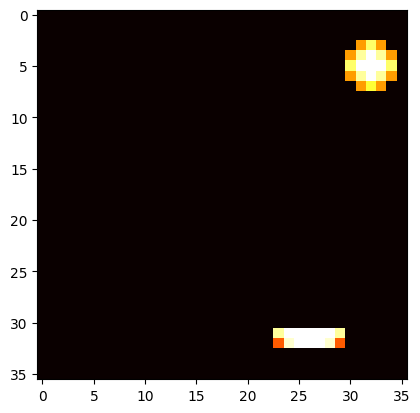

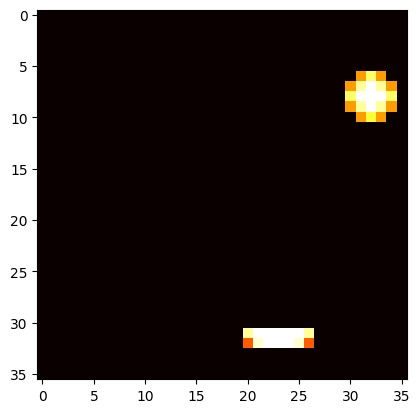

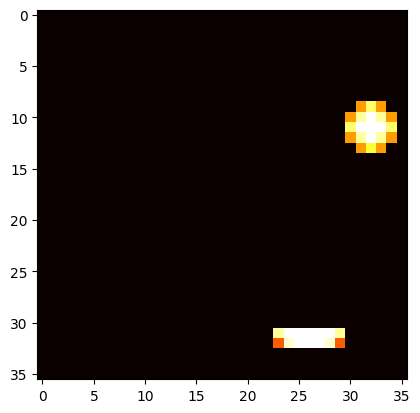

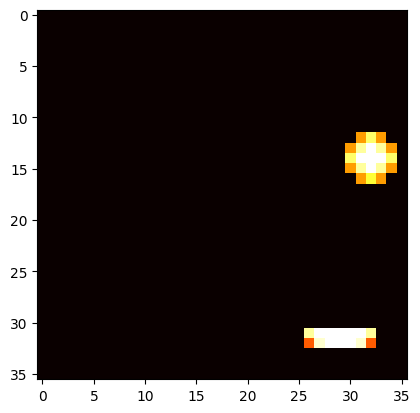

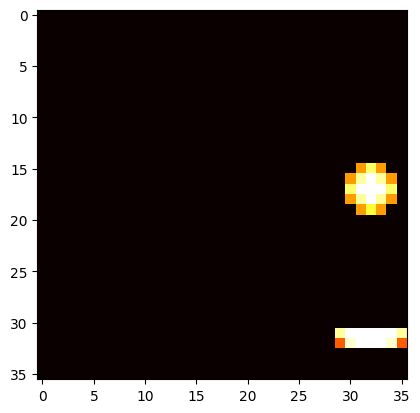

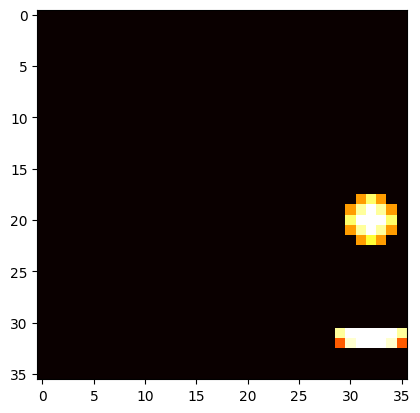

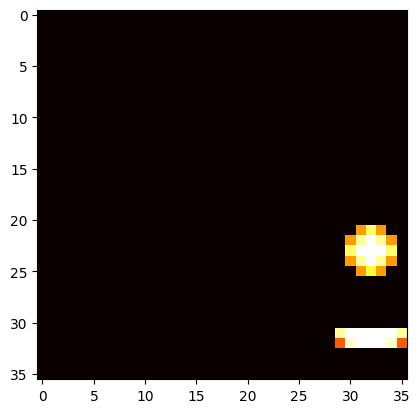

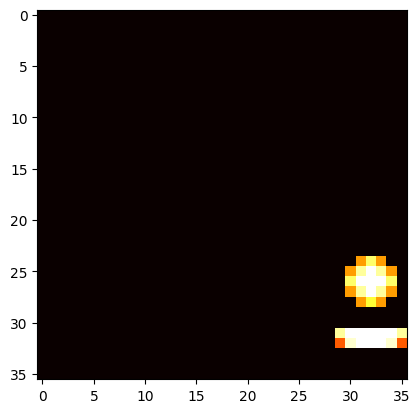

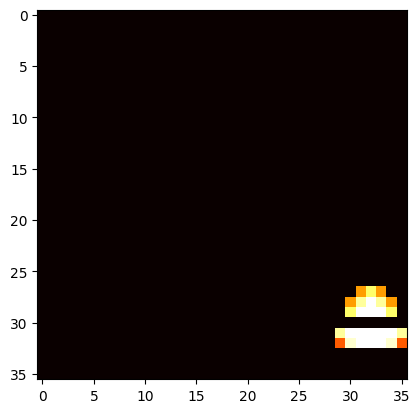

In [91]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    plt.figure()
    plt.imshow(np.flip(obs[0].squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward = agent._step()
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break

In [92]:
agent._Vs_on_last_episode

[0,
 tensor(0.5224, device='cuda:0'),
 tensor(0.5970, device='cuda:0'),
 tensor(0.8059, device='cuda:0'),
 tensor(1.0443, device='cuda:0'),
 tensor(1.1207, device='cuda:0'),
 tensor(1.0268, device='cuda:0'),
 tensor(0.8596, device='cuda:0'),
 tensor(1.3455, device='cuda:0')]